In [1]:
import pandas as pd
import re

# Configuration
DATA_DIR = r'C:\Users\aserilevi\code\dental_visits'

FILES = {
    'dental_2023': f'{DATA_DIR}\\dental_meps_2023.dta',
    'meps_2023': f'{DATA_DIR}\\meps_2023.dta',
    'dental_2022': f'{DATA_DIR}\\dental_meps_2022.dta',
    'meps_2022': f'{DATA_DIR}\\meps_2022.dta'
}

Data Loading and Cleaning

In [2]:
# Load all datasets
df_dental_2023 = pd.read_stata(FILES['dental_2023'])
df_meps_2023 = pd.read_stata(FILES['meps_2023'])
df_dental_2022 = pd.read_stata(FILES['dental_2022'])
df_meps_2022 = pd.read_stata(FILES['meps_2022'])

print(f"dental_meps_2023.dta has {len(df_dental_2023)} rows")
print(f"meps_2023.dta has {len(df_meps_2023)} rows")
print(f"dental_meps_2022.dta has {len(df_dental_2022)} rows")
print(f"meps_2022.dta has {len(df_meps_2022)} rows")

# Lowercase all column names in all datasets
df_dental_2023.columns = df_dental_2023.columns.str.lower()
df_meps_2023.columns = df_meps_2023.columns.str.lower()
df_dental_2022.columns = df_dental_2022.columns.str.lower()
df_meps_2022.columns = df_meps_2022.columns.str.lower()

# Fix MEPS 2022 columns
df_meps_2022.rename(columns={
    'dntins22_m23': 'dntins22'  # Remove _m23 suffix
}, inplace=True)

# Fix MEPS 2023 columns  
df_meps_2023.rename(columns={
    'prvhmo23_m23': 'prvhmo23',  # Remove _m23 suffix
    'dntins23_m23': 'dntins23'   # Remove _m23 suffix
    
}, inplace=True)

dental_meps_2023.dta has 19599 rows
meps_2023.dta has 18919 rows
dental_meps_2022.dta has 22529 rows
meps_2022.dta has 22431 rows


In [3]:
# FIX THE SPECIAL fftot VARIABLE (before merging)
df_dental_2022.rename(columns={'fftot23': 'fftot22'}, inplace=True)
df_dental_2023.rename(columns={'fftot24': 'fftot23'}, inplace=True)

Merge and aggregate to person-level

In [4]:
def aggregate_to_person_year(df, year):
    """
    Aggregate visit-level data to person-year level.
    - Count dental visits per person
    - Keep MEPS variables (they're the same across all rows for a person)
    """
    
    # Create binary indicators for visits
    df['had_cleaning'] = (df['clentetx'] == '1 YES').astype(int)
    df['had_exam'] = (df['examinex'] == '1 YES').astype(int)
    
    # Get all MEPS columns (not dental columns)
    meps_cols = [col for col in df.columns if not col.endswith('_dental') and col not in ['had_cleaning', 'had_exam']]
    
    # Aggregation rules
    agg_dict = {
        'had_cleaning': 'sum',  # Count cleanings
        'had_exam': 'sum',      # Count exams
    }
    
    # For MEPS variables, take the first value (they should all be the same for a person)
    for col in meps_cols:
        if col != 'dupersid':  # Don't aggregate the ID
            agg_dict[col] = 'first'
    
    # Group by person and aggregate
    df_person_year = df.groupby('dupersid').agg(agg_dict).reset_index()
    
    # Rename count columns
    df_person_year.rename(columns={
        'had_cleaning': 'num_cleanings',
        'had_exam': 'num_exams'
    }, inplace=True)
    
    # Add year
    df_person_year['year'] = year
    
    return df_person_year

In [5]:
# Step 1: Merge dental with meps for each year (KEEP ALL MEPS PEOPLE)
df_merged_2023 = pd.merge(df_dental_2023, df_meps_2023, on='dupersid', how='right', suffixes=('_dental', '_meps'))
df_merged_2022 = pd.merge(df_dental_2022, df_meps_2022, on='dupersid', how='right', suffixes=('_dental', '_meps'))

print(f"After merge (visit-level):")
print(f"  2022: {len(df_merged_2022):,} rows")
print(f"  2023: {len(df_merged_2023):,} rows")

# Step 2: AGGREGATE TO PERSON-YEAR LEVEL
df_2022_person_year = aggregate_to_person_year(df_merged_2022, 2022)
df_2023_person_year = aggregate_to_person_year(df_merged_2023, 2023)

print(f"\nAfter aggregation to person-year level:")
print(f"  2022: {len(df_2022_person_year):,} rows (one per person)")
print(f"  2023: {len(df_2023_person_year):,} rows (one per person)")

# Step 3: Find individuals in both years
both_year_ids = set(df_2022_person_year['dupersid']).intersection(set(df_2023_person_year['dupersid']))
print(f"\nIndividuals in BOTH years: {len(both_year_ids):,}")

# Step 4: Filter to only include people in both years
df_2022_filtered = df_2022_person_year[df_2022_person_year['dupersid'].isin(both_year_ids)].copy()
df_2023_filtered = df_2023_person_year[df_2023_person_year['dupersid'].isin(both_year_ids)].copy()

print(f"\nFiltered to panel (people in both years):")
print(f"  2022: {len(df_2022_filtered):,} rows")
print(f"  2023: {len(df_2023_filtered):,} rows")

After merge (visit-level):
  2022: 35,133 rows
  2023: 29,935 rows

After aggregation to person-year level:
  2022: 22,431 rows (one per person)
  2023: 18,919 rows (one per person)

Individuals in BOTH years: 8,284

Filtered to panel (people in both years):
  2022: 8,284 rows
  2023: 8,284 rows


Imputing everserved varaible from 2023 to 2022

In [6]:
print("="*60)
print("IMPUTING EVERSERVED FROM 2023 TO 2022")
print("="*60)

# Check if everserved exists in 2023 data
if 'everserved' in df_2023_filtered.columns:
    print("\n✓ everserved found in 2023 data")
    
    # Create mapping: dupersid → everserved value from 2023
    everserved_map = df_2023_filtered[['dupersid', 'everserved']].copy()
    everserved_map.columns = ['dupersid', 'everserved_from_2023']
    
    # Merge to 2022 data
    df_2022_filtered = df_2022_filtered.merge(everserved_map, on='dupersid', how='left')
    
    # If 2022 doesn't have everserved column, create it
    if 'everserved' not in df_2022_filtered.columns:
        df_2022_filtered['everserved'] = df_2022_filtered['everserved_from_2023']
        print("   ✓ Created everserved in 2022 from 2023 values")
    else:
        # Fill missing values in 2022 with 2023 values
        mask_missing = df_2022_filtered['everserved'].isna()
        df_2022_filtered.loc[mask_missing, 'everserved'] = df_2022_filtered.loc[mask_missing, 'everserved_from_2023']
        print(f"   ✓ Imputed {mask_missing.sum():,} missing values in 2022")
    
    # Drop temporary column
    df_2022_filtered.drop(columns=['everserved_from_2023'], inplace=True)
    
    # Check results
    print(f"\n2022 everserved: {(df_2022_filtered['everserved'].notna().sum()/len(df_2022_filtered)*100):.1f}% non-missing")
    print(f"2023 everserved: {(df_2023_filtered['everserved'].notna().sum()/len(df_2023_filtered)*100):.1f}% non-missing")
else:
    print("\n✗ everserved not found in 2023 data")

IMPUTING EVERSERVED FROM 2023 TO 2022

✓ everserved found in 2023 data
   ✓ Created everserved in 2022 from 2023 values

2022 everserved: 100.0% non-missing
2023 everserved: 100.0% non-missing


## Column name standardization: Column names contain year suffixes (22, 23) that need to be removed so that when we stack the two years, variables align properly. Otherwise, we'd have separate columns for `fftot22` and `fftot23` instead of one unified `fftot` column.

In [7]:
def rename_year_columns(df, year):
    """
    Rename columns where year (22 or 23) appears at the start or end of a digit sequence.
    """
    new_columns = []
    year_str = str(year)[-2:]  # '22' or '23'
    
    for col in df.columns:
        # Pattern 1: year at the END of the string (e.g., fftot22 -> fftot)
        if col.endswith(year_str):
            new_col = col[:-2]
        
        # Pattern 2: year followed by non-digit (e.g., dvmr22x -> dvmrx)
        elif re.search(rf'{year_str}(?=\D)', col):
            new_col = re.sub(rf'{year_str}(?=\D)', '', col)
        
        # Pattern 3: year at START of a digit sequence (e.g., dsch2253 -> dsch53)
        elif re.search(rf'(?<=\D){year_str}(?=\d)', col):
            new_col = re.sub(rf'(?<=\D){year_str}(?=\d)', '', col)
        
        else:
            new_col = col
        
        new_columns.append(new_col)
    
    df.columns = new_columns
    return df

In [8]:
# Apply the renaming pattern to both years
df_2022_filtered = rename_year_columns(df_2022_filtered, 2022)
df_2023_filtered = rename_year_columns(df_2023_filtered, 2023)

Concatenate 2022 and 2023 datasets

In [9]:
# Concatenate both years
dental_panel = pd.concat([df_2022_filtered, df_2023_filtered], ignore_index=True)

# Check results
print(f"\n{'='*60}")
print("FINAL PANEL DATASET")
print(f"{'='*60}")
print(f"Total rows: {len(dental_panel):,}")
print(f"Unique individuals: {dental_panel['dupersid'].nunique():,}")
print(f"Total columns: {len(dental_panel.columns):,}")
print(f"\nColumns with '22': {len([col for col in dental_panel.columns if '22' in col])}")
print(f"Columns with '23': {len([col for col in dental_panel.columns if '23' in col])}")

# Check if fftot was handled correctly
if 'fftot' in dental_panel.columns:
    print(f"\n✓ 'fftot' column exists (correctly renamed)")
    print(f"  Non-null values in 2022: {dental_panel[dental_panel['year']==2022]['fftot'].notna().sum()}")
    print(f"  Non-null values in 2023: {dental_panel[dental_panel['year']==2023]['fftot'].notna().sum()}")
else:
    print("\n✗ 'fftot' column not found")


FINAL PANEL DATASET
Total rows: 16,568
Unique individuals: 8,284
Total columns: 1,548

Columns with '22': 0
Columns with '23': 10

✓ 'fftot' column exists (correctly renamed)
  Non-null values in 2022: 3778
  Non-null values in 2023: 3702


In [10]:
# Check which columns still have '23' in them
cols_with_23 = [col for col in dental_panel.columns if '23' in col]
print("Columns still containing '23':")
for col in cols_with_23:
    print(f"  {col}")

Columns still containing '23':
  fcsz1231
  fcrp1231
  fmrs1231
  fams1231
  insc1231
  dsft2353
  dsey2353
  dsch2353
  dsfl2353
  dentin53_m23


In [11]:
# Drop columns we don't need that still contain '23'
cols_to_drop = ['fcsz1231', 'fcrp1231', 'fmrs1231', 'fams1231', 'insc1231', 
                'dsft2353', 'dsey2353', 'dsch2353', 'dsfl2353', 'dentin53_m23']

dental_panel = dental_panel.drop(columns=cols_to_drop, errors='ignore')

print(f"\nAfter dropping unnecessary columns:")
print(f"Total columns: {len(dental_panel.columns):,}")
print(f"Columns with '23': {len([col for col in dental_panel.columns if '23' in col])}")

dental_panel_clean = dental_panel.copy()


After dropping unnecessary columns:
Total columns: 1,538
Columns with '23': 0


## Create analytical dataset

In [12]:
print("\n" + "="*60)
print("CLEANING POVERTY LEVEL (POVLEV)")
print("="*60)

n_original = len(dental_panel_clean)
n_negative = (dental_panel_clean['povlev'] < 0).sum()
pct_negative = n_negative / n_original * 100

print(f"\nObservations with negative povlev: {n_negative:,} ({pct_negative:.2f}%)")

if n_negative > 0:
    print("\nNegative values found:")
    neg_vals = dental_panel_clean[dental_panel_clean['povlev'] < 0]['povlev'].sort_values()
    for i, val in enumerate(neg_vals, 1):
        print(f"  {i}. {val:>10.2f}")
    
    print("\nRemoving observations with negative poverty levels")
 
    
    # Remove negative values
    dental_panel_clean = dental_panel_clean[dental_panel_clean['povlev'] >= 0].copy()
    
    n_final = len(dental_panel_clean)
    n_removed = n_original - n_final
    
    print(f"\n✓ Removed {n_removed:,} observations ({n_removed/n_original*100:.2f}%)")
    print(f"  Original: {n_original:,}")
    print(f"  Final:    {n_final:,}")
    
    # Show new distribution
    print("\nCleaned povlev distribution:")
    print(f"  Min:     {dental_panel_clean['povlev'].min():.2f}")
    print(f"  Max:     {dental_panel_clean['povlev'].max():.2f}")
    print(f"  Mean:    {dental_panel_clean['povlev'].mean():.2f}")
    print(f"  Median:  {dental_panel_clean['povlev'].median():.2f}")
    print(f"  N:       {len(dental_panel_clean):,}")
else:
    print("\n✓ No negative values found!")

print("="*60)


CLEANING POVERTY LEVEL (POVLEV)

Observations with negative povlev: 10 (0.06%)

Negative values found:
  1.   -2189.77
  2.    -677.31
  3.    -167.96
  4.     -18.01
  5.     -18.01
  6.     -10.48
  7.     -10.48
  8.     -10.48
  9.     -10.48
  10.      -1.57

Removing observations with negative poverty levels

✓ Removed 10 observations (0.06%)
  Original: 16,568
  Final:    16,558

Cleaned povlev distribution:
  Min:     0.00
  Max:     4231.49
  Mean:    405.29
  Median:  308.52
  N:       16,558


In [13]:
print("="*60)
print("CREATING ANALYTICAL DATASET")
print("="*60)

# Define variables
predictors = [
    'sex', 'racethx', 'bornusa', 'othlgspk', 'marryx', 'hideg', 'povlev',
    'occcat31', 'inscov', 'explop42', 'everserved', 'dntins', 'region',
    'empst42', 'union31', 'haveus42', 'typepe42','agex'
]

outcome = 'num_cleanings'
id_var = 'dupersid'
time_var = 'year'

# Create analytical dataset
analysis_vars = [id_var, time_var, outcome] + predictors
df_analysis = dental_panel_clean[analysis_vars].copy()

print(f"\n✓ Created analytical dataset")
print(f"  Observations (before age filter): {len(df_analysis):,}")
print(f"  Variables: {len(analysis_vars)}")
print(f"  People (before age filter): {df_analysis[id_var].nunique():,}")
print(f"  Years: {sorted(df_analysis[time_var].unique())}")

# RESTRICT TO ADULTS 25+
print(f"\n{'='*60}")
print("RESTRICTING ANALYSIS TO ADULTS AGE 25+")
print(f"{'='*60}")
print(f"  Observations before filter: {len(df_analysis):,}")
print(f"  Age range before filter: {df_analysis['agex'].min():.0f} - {df_analysis['agex'].max():.0f}")

df_analysis = df_analysis[df_analysis['agex'] > 24].copy()

print(f"\n  Observations after filter: {len(df_analysis):,}")
print(f"  Observations dropped: {len(dental_panel_clean[analysis_vars]) - len(df_analysis):,}")
print(f"  Age range after filter: {df_analysis['agex'].min():.0f} - {df_analysis['agex'].max():.0f}")
print(f"  People (age 25+): {df_analysis[id_var].nunique():,}")
print(f"\n✓ Analysis restricted to adults age 25+")

# CONSOLIDATE EMPLOYMENT STATUS CATEGORIES
print("\n" + "="*60)
print("CONSOLIDATING EMPLOYMENT STATUS (EMPST42)")
print("="*60)
print("\nConsolidating detailed employment categories into binary employed/not employed.")
print("\nOriginal categories:")
print(df_analysis['empst42'].value_counts().sort_index())

# Create mapping
employment_mapping = {
    '1 EMPLOYED AT RD 4/2 INT DATE': 'Employed',
    '2 JOB TO RETURN TO AT RD 4/2 INT DATE': 'Employed',
    '3 JOB DURING RD 4/2 REF PERIOD': 'Employed',
    '4 NOT EMPLOYED DURING RD 4/2': 'Not Employed',
    '-15 CANNOT BE COMPUTED': 'Not Employed',  # Treat as not employed
    '-7 REFUSED': 'Not Employed',  # Conservative: treat as not employed
    '-8 DON\'T KNOW': 'Not Employed',  # Conservative: treat as not employed
    '-1 INAPPLICABLE': 'Not Employed'  # Likely children/not in labor force
}

# Apply mapping
df_analysis['empst42'] = df_analysis['empst42'].map(employment_mapping)

print("\n" + "-"*60)
print("Consolidated categories:")
print("-"*60)
print(df_analysis['empst42'].value_counts().sort_index())

n_employed = (df_analysis['empst42'] == 'Employed').sum()
n_not_employed = (df_analysis['empst42'] == 'Not Employed').sum()
pct_employed = n_employed / len(df_analysis) * 100

print(f"\n✓ Employment status consolidated:")
print(f"  Employed:     {n_employed:>6,} ({pct_employed:>5.1f}%)")
print(f"  Not Employed: {n_not_employed:>6,} ({100-pct_employed:>5.1f}%)")
print(f"\nNote: Reference category for regression will be 'Not Employed'")
print("="*60)

# REMOVE PROBLEMATIC RESPONSE CATEGORIES
print("\n" + "="*60)
print("REMOVING PROBLEMATIC RESPONSE CATEGORIES")
print("="*60)
print("\nRemoving observations with refused/don't know/inapplicable responses")
print("to avoid perfect separation issues in logistic regression.")

# Store original size
n_original = len(df_analysis)

# Define problematic values for each variable
problematic_filters = {
    'bornusa': ['-7 REFUSED', '-8 DON\'T KNOW'],
    'othlgspk': ['-7 REFUSED', '-8 DON\'T KNOW'],
    'marryx': ['-7 REFUSED'],
    'hideg': ['-8 DON\'T KNOW', '-7 REFUSED'],
    'everserved': ['-7 REFUSED', '-8 DON\'T KNOW'],
    'haveus42': ['-1 INAPPLICABLE', '-7 REFUSED', '-8 DON\'T KNOW']
}

# Track what we're removing
removal_summary = []

# Apply filters
keep_mask = pd.Series(True, index=df_analysis.index)

for var, bad_values in problematic_filters.items():
    if var in df_analysis.columns:
        for bad_value in bad_values:
            n_flagged = (df_analysis[var] == bad_value).sum()
            if n_flagged > 0:
                pct = n_flagged / len(df_analysis) * 100
                removal_summary.append({
                    'variable': var,
                    'value': bad_value,
                    'n': n_flagged,
                    'pct': pct
                })
                # Update mask to exclude these observations
                keep_mask = keep_mask & (df_analysis[var] != bad_value)

# Show what we're removing
if len(removal_summary) > 0:
    print(f"\nObservations to remove by category:")
    print(f"{'Variable':<15} {'Value':<25} {'N':>8} {'%':>8}")
    print("-" * 60)
    for item in removal_summary:
        print(f"{item['variable']:<15} {item['value']:<25} {item['n']:>8,} {item['pct']:>7.2f}%")
    
    # Apply the filter
    df_analysis = df_analysis[keep_mask].copy()
    
    n_dropped = n_original - len(df_analysis)
    pct_dropped = n_dropped / n_original * 100
    
    print(f"\n{'='*60}")
    print(f"SUMMARY:")
    print(f"  Original observations:     {n_original:>8,}")
    print(f"  Observations removed:      {n_dropped:>8,} ({pct_dropped:>5.2f}%)")
    print(f"  Final observations:        {len(df_analysis):>8,}")
    print(f"  Unique individuals:        {df_analysis['dupersid'].nunique():>8,}")
    print(f"\n✓ Cleaned dataset ready for analysis")
else:
    print("\n  ✓ No problematic responses found in dataset!")

print("="*60)

# Create binary outcome for Part 1 (any cleaning vs none)
df_analysis['any_cleaning'] = (df_analysis[outcome] > 0).astype(int)

print(f"\n✓ Created binary outcome variable 'any_cleaning'")
print(f"  0 cleanings: {(df_analysis['any_cleaning']==0).sum():,} ({(df_analysis['any_cleaning']==0).sum()/len(df_analysis)*100:.1f}%)")
print(f"  1+ cleanings: {(df_analysis['any_cleaning']==1).sum():,} ({(df_analysis['any_cleaning']==1).sum()/len(df_analysis)*100:.1f}%)")

# Create subset for Part 2 (only those with 1+ cleanings)
df_part2 = df_analysis[df_analysis[outcome] > 0].copy()

print(f"\n✓ Created Part 2 dataset (conditional on 1+ cleanings)")
print(f"  Observations: {len(df_part2):,}")
print(f"  Mean cleanings: {df_part2[outcome].mean():.2f}")
print(f"  Distribution:")
print(df_part2[outcome].value_counts().sort_index())

# Summary statistics by insurance status
print("\n" + "="*60)
print("DESCRIPTIVE STATISTICS BY INSURANCE STATUS")
print("="*60)

for ins_status in ['1 YES', '2 NO']:
    subset = df_analysis[df_analysis['dntins'] == ins_status]
    print(f"\n{ins_status} (n={len(subset):,}):")
    print(f"  % with any cleaning: {(subset['any_cleaning']==1).sum()/len(subset)*100:.1f}%")
    print(f"  Mean cleanings (overall): {subset[outcome].mean():.2f}")
    
    subset_nonzero = subset[subset[outcome] > 0]
    if len(subset_nonzero) > 0:
        print(f"  Mean cleanings (among 1+): {subset_nonzero[outcome].mean():.2f}")



CREATING ANALYTICAL DATASET

✓ Created analytical dataset
  Observations (before age filter): 16,558
  Variables: 21
  People (before age filter): 8,284
  Years: [np.int64(2022), np.int64(2023)]

RESTRICTING ANALYSIS TO ADULTS AGE 25+
  Observations before filter: 16,558
  Age range before filter: -1 - 85

  Observations after filter: 12,211
  Observations dropped: 4,347
  Age range after filter: 25 - 85
  People (age 25+): 6,179

✓ Analysis restricted to adults age 25+

CONSOLIDATING EMPLOYMENT STATUS (EMPST42)

Consolidating detailed employment categories into binary employed/not employed.

Original categories:
empst42
-15 CANNOT BE COMPUTED                     11
-8 DON'T KNOW                              23
-7 REFUSED                                 50
-1 INAPPLICABLE                            28
1 EMPLOYED AT RD 4/2 INT DATE            6957
2 JOB TO RETURN TO AT RD 4/2 INT DATE      28
3 JOB DURING RD 4/2 REF PERIOD            376
4 NOT EMPLOYED DURING RD 4/2             4738
Nam

DISTRIBUTION OF DENTAL CLEANINGS (AMONG THOSE WITH 1+ CLEANINGS)

📊 DESCRIPTIVE STATISTICS
--------------------------------------------------------------------------------
Sample size: 4,285
Mean cleanings: 1.59
Median cleanings: 1
Std deviation: 0.74
Min: 1
Max: 13

📈 PERCENTILES
--------------------------------------------------------------------------------
25th percentile: 1
50th percentile: 1
75th percentile: 2
90th percentile: 2
95th percentile: 3
99th percentile: 4

📋 FREQUENCY DISTRIBUTION
--------------------------------------------------------------------------------
num_cleanings
1     2222
2     1695
3      288
4       66
5        8
6        5
13       1
Name: count, dtype: int64

📊 PERCENTAGE DISTRIBUTION
--------------------------------------------------------------------------------
1 cleanings: 51.9%
2 cleanings: 39.6%
3 cleanings: 6.7%
4 cleanings: 1.5%
5 cleanings: 0.2%
6 cleanings: 0.1%
13 cleanings: 0.0%

📈 CUMULATIVE DISTRIBUTION
-----------------------------------

C:\Users\aserilevi\AppData\Local\Temp\ipykernel_25652\2625679553.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  insurance_groups = df_part2.groupby('dntins')['num_cleanings'].apply(



✅ Visualization saved as 'cleaning_distribution.png'


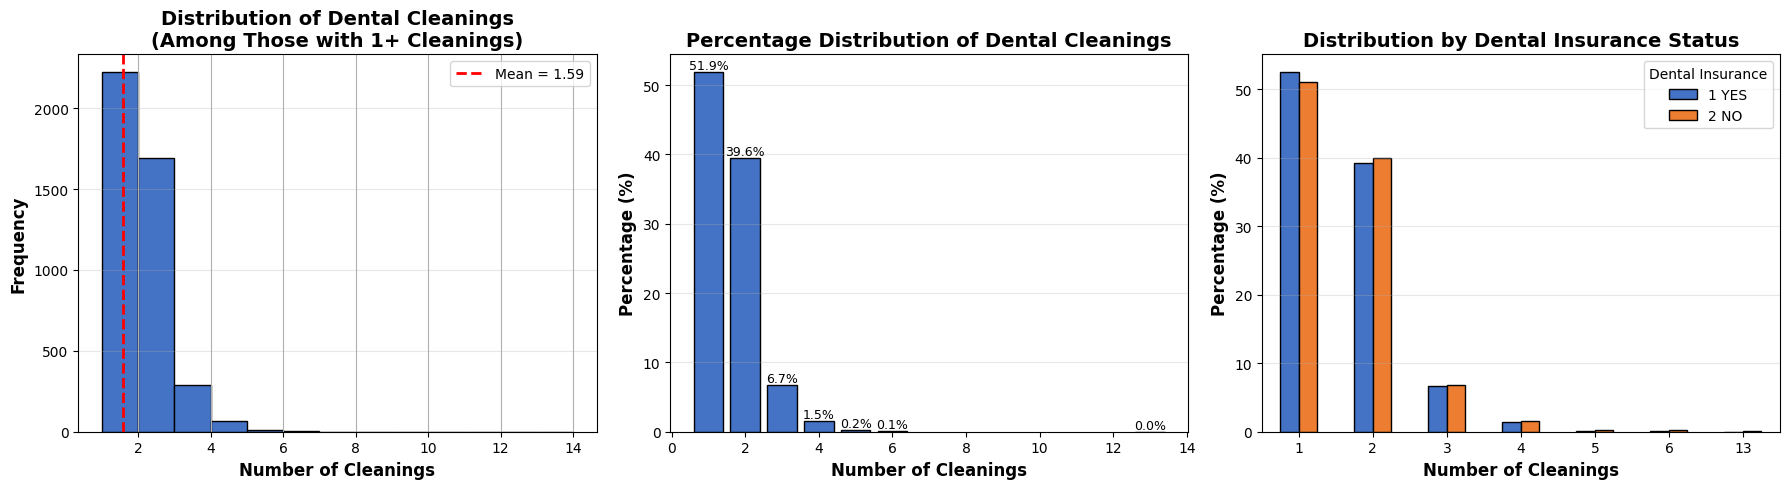


TABLE: Distribution of Dental Cleanings Among Users
 Number of Cleanings  Frequency Percentage Cumulative %
                   1       2222      51.9%        51.9%
                   2       1695      39.6%        91.4%
                   3        288       6.7%        98.1%
                   4         66       1.5%        99.7%
                   5          8       0.2%        99.9%
                   6          5       0.1%       100.0%
                  13          1       0.0%       100.0%

✅ Table saved as 'cleaning_distribution_table.csv'


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("="*80)
print("DISTRIBUTION OF DENTAL CLEANINGS (AMONG THOSE WITH 1+ CLEANINGS)")
print("="*80)

# Basic statistics
print("\n📊 DESCRIPTIVE STATISTICS")
print("-"*80)
print(f"Sample size: {len(df_part2):,}")
print(f"Mean cleanings: {df_part2['num_cleanings'].mean():.2f}")
print(f"Median cleanings: {df_part2['num_cleanings'].median():.0f}")
print(f"Std deviation: {df_part2['num_cleanings'].std():.2f}")
print(f"Min: {df_part2['num_cleanings'].min():.0f}")
print(f"Max: {df_part2['num_cleanings'].max():.0f}")

# Percentiles
print("\n📈 PERCENTILES")
print("-"*80)
percentiles = [25, 50, 75, 90, 95, 99]
for p in percentiles:
    val = np.percentile(df_part2['num_cleanings'], p)
    print(f"{p}th percentile: {val:.0f}")

# Frequency distribution
print("\n📋 FREQUENCY DISTRIBUTION")
print("-"*80)
freq_dist = df_part2['num_cleanings'].value_counts().sort_index()
print(freq_dist)

# Percentage distribution
print("\n📊 PERCENTAGE DISTRIBUTION")
print("-"*80)
pct_dist = (df_part2['num_cleanings'].value_counts(normalize=True).sort_index() * 100)
for val, pct in pct_dist.items():
    print(f"{val} cleanings: {pct:.1f}%")

# Cumulative distribution
print("\n📈 CUMULATIVE DISTRIBUTION")
print("-"*80)
cum_dist = df_part2['num_cleanings'].value_counts(normalize=True).sort_index().cumsum() * 100
for val, cum_pct in cum_dist.items():
    print(f"≤ {val} cleanings: {cum_pct:.1f}%")

# Distribution by insurance status
print("\n" + "="*80)
print("DISTRIBUTION BY DENTAL INSURANCE STATUS")
print("="*80)

for ins_status in df_part2['dntins'].unique():
    subset = df_part2[df_part2['dntins'] == ins_status]
    print(f"\n{ins_status} (n={len(subset):,})")
    print("-"*40)
    print(f"  Mean: {subset['num_cleanings'].mean():.2f}")
    print(f"  Median: {subset['num_cleanings'].median():.0f}")
    print(f"  Std Dev: {subset['num_cleanings'].std():.2f}")
    print("\n  Distribution:")
    dist = subset['num_cleanings'].value_counts(normalize=True).sort_index() * 100
    for val, pct in dist.items():
        print(f"    {val} cleanings: {pct:.1f}%")

# Create visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Histogram
ax1 = axes[0]
df_part2['num_cleanings'].hist(bins=range(1, df_part2['num_cleanings'].max()+2), 
                                 edgecolor='black', color='#4472C4', ax=ax1)
ax1.set_xlabel('Number of Cleanings', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of Dental Cleanings\n(Among Those with 1+ Cleanings)', 
              fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add mean line
mean_val = df_part2['num_cleanings'].mean()
ax1.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_val:.2f}')
ax1.legend()

# 2. Bar chart with percentages
ax2 = axes[1]
pct_dist_plot = (df_part2['num_cleanings'].value_counts(normalize=True).sort_index() * 100)
bars = ax2.bar(pct_dist_plot.index, pct_dist_plot.values, edgecolor='black', color='#4472C4')
ax2.set_xlabel('Number of Cleanings', fontsize=12, fontweight='bold')
ax2.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax2.set_title('Percentage Distribution of Dental Cleanings', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# 3. Comparison by insurance status
ax3 = axes[2]
insurance_groups = df_part2.groupby('dntins')['num_cleanings'].apply(
    lambda x: x.value_counts(normalize=True).sort_index() * 100
).unstack(fill_value=0)

insurance_groups.T.plot(kind='bar', ax=ax3, color=['#4472C4', '#ED7D31'], edgecolor='black')
ax3.set_xlabel('Number of Cleanings', fontsize=12, fontweight='bold')
ax3.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax3.set_title('Distribution by Dental Insurance Status', fontsize=14, fontweight='bold')
ax3.legend(title='Dental Insurance', fontsize=10)
ax3.grid(axis='y', alpha=0.3)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)


plt.tight_layout()
plt.savefig('cleaning_distribution.png', dpi=300, bbox_inches='tight')
print("\n✅ Visualization saved as 'cleaning_distribution.png'")
plt.show()

# Create a simple table for the paper
print("\n" + "="*80)
print("TABLE: Distribution of Dental Cleanings Among Users")
print("="*80)

table_data = []
for val in sorted(df_part2['num_cleanings'].unique()):
    n = (df_part2['num_cleanings'] == val).sum()
    pct = (df_part2['num_cleanings'] == val).mean() * 100
    cum_pct = (df_part2['num_cleanings'] <= val).mean() * 100
    table_data.append({
        'Number of Cleanings': int(val),
        'Frequency': n,
        'Percentage': f'{pct:.1f}%',
        'Cumulative %': f'{cum_pct:.1f}%'
    })

table_df = pd.DataFrame(table_data)
print(table_df.to_string(index=False))

# Save to CSV
table_df.to_csv('cleaning_distribution_table.csv', index=False)
print("\n✅ Table saved as 'cleaning_distribution_table.csv'")


## Descriptive statistics

In [15]:
print("="*60)
print("COMPREHENSIVE DESCRIPTIVE STATISTICS")
print("="*60)

import numpy as np

# Separate continuous and categorical variables
continuous_vars = ['povlev', 'agex']
categorical_vars = [
    'sex', 'racethx', 'bornusa', 'othlgspk', 'marryx', 'hideg',
     'inscov', 'explop42', 'everserved', 'dntins', 
     'empst42', 'haveus42', #occcat31', #'region', #'union31'
]

print(f"\nContinuous variables: {continuous_vars}")
print(f"Categorical variables: {len(categorical_vars)} variables")

# ============================================================
# CONTINUOUS VARIABLES
# ============================================================
print("\n" + "="*60)
print("CONTINUOUS VARIABLES - DETAILED STATISTICS")
print("="*60)

for var in continuous_vars:
    print(f"\n{var.upper()}")
    print("-" * 60)
    
    data = df_analysis[var].dropna()
    
    # Basic statistics
    print(f"  N (non-missing):     {len(data):,}")
    print(f"  Mean:                {data.mean():.2f}")
    print(f"  Median:              {data.median():.2f}")
    print(f"  Std Dev:             {data.std():.2f}")
    print(f"  Min:                 {data.min():.2f}")
    print(f"  Max:                 {data.max():.2f}")
    print(f"  Range:               {data.max() - data.min():.2f}")
    
    # Quartiles
    print(f"\n  Quartiles:")
    print(f"    25th percentile:   {data.quantile(0.25):.2f}")
    print(f"    50th percentile:   {data.quantile(0.50):.2f}")
    print(f"    75th percentile:   {data.quantile(0.75):.2f}")
   
    
    # Additional percentiles
    print(f"\n  Additional percentiles:")
    print(f"    10th percentile:   {data.quantile(0.10):.2f}")
    print(f"    90th percentile:   {data.quantile(0.90):.2f}")
    
   
    
    # Distribution by bands
    if var == 'povlev':
        # Poverty level bands (% of federal poverty line)
        bands = [0, 100, 200, 300, 400, 500, float('inf')]
        labels = ['<100%', '100-200%', '200-300%', '300-400%', '400-500%', '500%+']
        
        print(f"\n  Distribution by bands:")
        data_binned = pd.cut(data, bins=bands, labels=labels, include_lowest=True)
        counts = data_binned.value_counts().sort_index()
        for label, count in counts.items():
            pct = count / len(data) * 100
            print(f"    {label:15s}: {count:6,} ({pct:5.1f}%)")
    
    if var == 'agex':
        # Age bands
        bands = [0, 6, 18, 26, 35, 50, 65, float('inf')]
        labels = ['0-5', '6-17', '18-25', '26-34', '35-49', '50-64', '65+']
        
        print(f"\n  Distribution by age bands:")
        data_binned = pd.cut(data, bins=bands, labels=labels, include_lowest=True)
        counts = data_binned.value_counts().sort_index()
        for label, count in counts.items():
            pct = count / len(data) * 100
            print(f"    {label:15s}: {count:6,} ({pct:5.1f}%)")

# ============================================================
# CATEGORICAL VARIABLES
# ============================================================
print("\n" + "="*60)
print("CATEGORICAL VARIABLES - FREQUENCY DISTRIBUTIONS")
print("="*60)

for var in categorical_vars:
    print(f"\n{var.upper()}")
    print("-" * 60)
    
    # Get value counts
    counts = df_analysis[var].value_counts(dropna=False)
    total = len(df_analysis)
    
    print(f"  Total observations: {total:,}")
    print(f"  Unique values: {df_analysis[var].nunique()}")
    print(f"\n  Distribution:")
    
    # Show all categories
    for value, count in counts.items():
        pct = count / total * 100
        # Create bar visualization
        bar_length = int(pct / 2)  # Scale to max 50 chars
        bar = '█' * bar_length
        print(f"    {str(value):40s} | {count:6,} ({pct:5.1f}%) {bar}")

# ============================================================
# OUTCOME VARIABLE
# ============================================================
print("\n" + "="*60)
print("OUTCOME VARIABLE - NUM_CLEANINGS")
print("="*60)

data = df_analysis['num_cleanings']

print(f"\n  N (non-missing):     {len(data):,}")
print(f"  Mean:                {data.mean():.2f}")
print(f"  Median:              {data.median():.0f}")
print(f"  Std Dev:             {data.std():.2f}")
print(f"  Min:                 {int(data.min())}")
print(f"  Max:                 {int(data.max())}")
print(f"  Variance:            {data.var():.2f}")
print(f"  Variance/Mean:       {data.var()/data.mean():.2f} (overdispersion check)")

print(f"\n  Distribution:")
counts = data.value_counts().sort_index()
for value, count in counts.items():
    pct = count / len(data) * 100
    bar_length = int(pct / 2)
    bar = '█' * bar_length
    print(f"    {int(value):2d} cleanings | {count:6,} ({pct:5.1f}%) {bar}")

print(f"\n  Binary outcome (any cleaning):")
print(f"    0 cleanings:  {(data==0).sum():6,} ({(data==0).sum()/len(data)*100:5.1f}%)")
print(f"    1+ cleanings: {(data>0).sum():6,} ({(data>0).sum()/len(data)*100:5.1f}%)")

# Among those with 1+ cleanings
data_nonzero = data[data > 0]
print(f"\n  Among those with 1+ cleanings (n={len(data_nonzero):,}):")
print(f"    Mean:    {data_nonzero.mean():.2f}")
print(f"    Median:  {data_nonzero.median():.0f}")
print(f"    Std Dev: {data_nonzero.std():.2f}")

print("\n" + "="*60)
print("DESCRIPTIVE STATISTICS COMPLETE!")
print("="*60)

COMPREHENSIVE DESCRIPTIVE STATISTICS

Continuous variables: ['povlev', 'agex']
Categorical variables: 12 variables

CONTINUOUS VARIABLES - DETAILED STATISTICS

POVLEV
------------------------------------------------------------
  N (non-missing):     11,633
  Mean:                433.72
  Median:              329.43
  Std Dev:             395.14
  Min:                 0.00
  Max:                 4231.49
  Range:               4231.49

  Quartiles:
    25th percentile:   165.79
    50th percentile:   329.43
    75th percentile:   578.89

  Additional percentiles:
    10th percentile:   81.22
    90th percentile:   908.79

  Distribution by bands:
    <100%          :  1,556 ( 13.4%)
    100-200%       :  2,012 ( 17.3%)
    200-300%       :  1,700 ( 14.6%)
    300-400%       :  1,537 ( 13.2%)
    400-500%       :  1,168 ( 10.0%)
    500%+          :  3,660 ( 31.5%)

AGEX
------------------------------------------------------------
  N (non-missing):     11,633
  Mean:                54.5

## Logistic regression analysis

In [16]:
print("\n" + "="*60)
print("STEP 1: CREATE DUMMY VARIABLES")
print("="*60)

# Define categorical variables to convert to dummies
categorical_vars = [
    'sex', 'racethx', 'marryx', 'hideg'
   , 'everserved', 'empst42', 'haveus42','dntins', #'explop42','bornusa', 'othlgspk',  'inscov'
]

# Define reference categories (these will be dropped)
reference_categories = {
    'sex': '1 MALE',
    'racethx': '2 NON-HISPANIC WHITE ONLY',
    #'bornusa': '1 YES',
    #'othlgspk': '2 NO',
    'marryx': '1 MARRIED',
    'hideg': '3 HIGH SCHOOL DIPLOMA',
    #'inscov': '1 ANY PRIVATE',
    #'explop42': '1 YES',
    'everserved': '2 NO - DID NOT SERVE IN MILITARY',
    'dntins': '2 NO',
    'empst42': 'Not Employed',
    'haveus42': '1 YES'
}

print("\nReference categories:")
for var, ref in reference_categories.items():
    print(f"  {var:<15s}: {ref}")

# check unique values in each categorical variable
print("\n" + "="*60)
print("Checking unique values in categorical variables...")
print("="*60)
for var in categorical_vars:
    unique_vals = df_analysis[var].unique()
    print(f"\n{var}: {len(unique_vals)} unique values")
    for val in sorted(unique_vals):
        count = (df_analysis[var] == val).sum()
        print(f"  {val}: {count:,}")

print("\n" + "="*60)
print("Creating dummy variables...")
print("="*60)

# Start with continuous variables and IDs
df_final = df_analysis[['dupersid', 'year', 'num_cleanings', 'any_cleaning', 'povlev', 'agex']].copy()

# Create dummies for each categorical variable
for var in categorical_vars:
    # Get dummies with dtype=int to ensure numeric
    dummies = pd.get_dummies(df_analysis[var], prefix=var, drop_first=False, dtype=int)
    
    # Drop reference category
    ref_col = f"{var}_{reference_categories[var]}"
    if ref_col in dummies.columns:
        dummies = dummies.drop(columns=[ref_col])
    
    # Skip if no dummies left (all same value)
    if len(dummies.columns) == 0:
        print(f"\n{var}:")
        print(f"  ⚠️ Skipped - only one unique value (no variation)")
        continue
    
    # Add to final dataset
    df_final = pd.concat([df_final, dummies], axis=1)
    
    print(f"\n{var}:")
    print(f"  ✓ Created {len(dummies.columns)} dummies (dropped reference: {reference_categories[var]})")
    if len(dummies.columns) <= 5:
        for col in dummies.columns:
            print(f"    - {col}")
    else:
        for col in list(dummies.columns)[:5]:
            print(f"    - {col}")
        print(f"    ... and {len(dummies.columns) - 5} more")

print("\n" + "="*60)
print(f"✓ Dummy variable creation complete!")
print(f"\nFinal dataset dimensions:")
print(f"  Observations: {len(df_final):,}")
print(f"  Variables: {len(df_final.columns):,}")
print(f"    - IDs/outcomes: 4 (dupersid, year, num_cleanings, any_cleaning)")
print(f"    - Continuous: 2 (povlev, agex)")
print(f"    - Dummies: {len(df_final.columns) - 6}")
print("="*60)


STEP 1: CREATE DUMMY VARIABLES

Reference categories:
  sex            : 1 MALE
  racethx        : 2 NON-HISPANIC WHITE ONLY
  marryx         : 1 MARRIED
  hideg          : 3 HIGH SCHOOL DIPLOMA
  everserved     : 2 NO - DID NOT SERVE IN MILITARY
  dntins         : 2 NO
  empst42        : Not Employed
  haveus42       : 1 YES

Checking unique values in categorical variables...

sex: 2 unique values
  1 MALE: 5,258
  2 FEMALE: 6,375

racethx: 5 unique values
  1 HISPANIC: 2,276
  2 NON-HISPANIC WHITE ONLY: 6,761
  3 NON-HISPANIC BLACK ONLY: 1,619
  4 NON-HISPANIC ASIAN ONLY: 672
  5 NON-HISPANIC OTHER RACE OR MULTIPLE RACE: 305

marryx: 5 unique values
  1 MARRIED: 6,259
  2 WIDOWED: 1,095
  3 DIVORCED: 1,652
  4 SEPARATED: 312
  5 NEVER MARRIED: 2,315

hideg: 7 unique values
  1 NO DEGREE: 1,365
  2 GED: 471
  3 HIGH SCHOOL DIPLOMA: 4,230
  4 BACHELOR'S DEGREE: 2,606
  5 MASTER'S DEGREE: 1,353
  6 DOCTORATE DEGREE: 385
  7 OTHER DEGREE: 1,223

everserved: 2 unique values
  1 YES - SER

In [17]:
print("="*60)
print("REMOVING ZERO-VARIANCE AND PROBLEMATIC COLUMNS")
print("="*60)

# Identify all zero-variance columns (excluding IDs and outcomes)
zero_var_cols = []
for col in df_final.columns:
    if col not in ['dupersid', 'year', 'num_cleanings', 'any_cleaning']:
        if df_final[col].std() == 0:
            zero_var_cols.append(col)

print(f"\nFound {len(zero_var_cols)} zero-variance columns:")
for col in zero_var_cols:
    print(f"  - {col}")

# Also check for columns with very low variance or very few 1s (potential perfect separation)
print("\n" + "-"*60)
print("Checking for potential perfect separation issues...")
print("-"*60)

low_var_cols = []
for col in df_final.columns:
    if col not in ['dupersid', 'year', 'num_cleanings', 'any_cleaning', 'povlev', 'agex']:
        # For dummy variables, check if very few 1s
        n_ones = df_final[col].sum()
        if n_ones < 10:  # Less than 10 observations with value=1
            low_var_cols.append((col, n_ones))

if low_var_cols:
    print(f"\nFound {len(low_var_cols)} columns with < 10 observations (potential perfect separation):")
    for col, n in sorted(low_var_cols, key=lambda x: x[1]):
        print(f"  - {col}: {n} observations")
    print("\n These columns may cause convergence issues and will be dropped.")
else:
    print("\n✓ No columns with very low counts found.")

# Combine all columns to drop
cols_to_drop = zero_var_cols + [col for col, _ in low_var_cols]

# Drop them
if cols_to_drop:
    print(f"\n" + "-"*60)
    print(f"Dropping {len(cols_to_drop)} problematic columns...")
    print("-"*60)
    df_final = df_final.drop(columns=cols_to_drop)
    print(f"✓ Dropped {len(cols_to_drop)} columns")
else:
    print("\n✓ No columns to drop")

print(f"\n" + "="*60)
print(f"FINAL DATASET FOR MODELING")
print("="*60)
print(f"  Observations: {len(df_final):,}")
print(f"  Variables: {len(df_final.columns):,}")
print(f"    - IDs/outcomes: 4 (dupersid, year, num_cleanings, any_cleaning)")
print(f"    - Continuous: 2 (povlev, agex)")
print(f"    - Dummies: {len(df_final.columns) - 6}")

print("\n✓ Dataset ready for logistic regression!")

REMOVING ZERO-VARIANCE AND PROBLEMATIC COLUMNS

Found 13 zero-variance columns:
  - marryx_-8 DON'T KNOW
  - marryx_-7 REFUSED
  - marryx_6 UNDER AGE 16 - INAPPLICABLE
  - hideg_-8 DON'T KNOW
  - hideg_-7 REFUSED
  - hideg_8 UNDER AGE 16 - INAPPLICABLE
  - everserved_-8 DON'T KNOW
  - everserved_-7 REFUSED
  - everserved_3 16 OR YOUNGER - INAPPLICABLE
  - haveus42_-8 DON'T KNOW
  - haveus42_-7 REFUSED
  - haveus42_-1 INAPPLICABLE
  - dntins_-1 INAPPLICABLE

------------------------------------------------------------
Checking for potential perfect separation issues...
------------------------------------------------------------

Found 13 columns with < 10 observations (potential perfect separation):
  - marryx_-8 DON'T KNOW: 0 observations
  - marryx_-7 REFUSED: 0 observations
  - marryx_6 UNDER AGE 16 - INAPPLICABLE: 0 observations
  - hideg_-8 DON'T KNOW: 0 observations
  - hideg_-7 REFUSED: 0 observations
  - hideg_8 UNDER AGE 16 - INAPPLICABLE: 0 observations
  - everserved_-8 DON'

In [18]:
import statsmodels.api as sm
from statsmodels.formula.api import logit


print("="*60)
print("EXPANDING MODEL V2: ADDING INTERACTION TERMS")
print("="*60)
print("\nAdding theoretically motivated interaction terms:")
print("1. Dental Insurance × Poverty Level (dntins × povlev)")
print("2. Dental Insurance × Usual Source of Care (dntins × haveus42)")

df_final_v2 = df_final.copy()

# Add squared terms
df_final_v2['povlev_sq'] = df_final_v2['povlev'].astype('float64')** 2
df_final_v2['agex_sq'] = df_final_v2['agex'].astype('int32') ** 2


# Start with df_final_v2 (which has povlev_sq)
df_final_v4 = df_final_v2.copy()

# SCALE POVERTY LEVEL FIRST
df_final_v4['povlev_scaled'] = df_final_v4['povlev'] / 1000
df_final_v4['povlev_sq_scaled'] = df_final_v4['povlev_scaled'] ** 2


# Create interaction terms
print("\n🔧 Creating interaction terms...")

# 1. Dental Insurance × Poverty Level
df_final_v4['dntins_x_povlev'] = df_final_v4['dntins_1 YES'] * df_final_v4['povlev_scaled']
print("  ✅ dntins_x_povlev: Tests if dental insurance helps more at different income levels")

# 2. Dental Insurance × No Usual Source of Care
df_final_v4['dntins_x_no_usc'] = df_final_v4['dntins_1 YES'] * df_final_v4['haveus42_2 NO']
print("  ✅ dntins_x_no_usc: Tests if dental insurance compensates for lack of usual care")


print(f"\n📊 Interaction term distributions:")
print(f"dntins_x_povlev: min={df_final_v4['dntins_x_povlev'].min():.0f}, max={df_final_v4['dntins_x_povlev'].max():.0f}")
if 'dntins_x_no_usc' in df_final_v4.columns:
    print(f"dntins_x_no_usc: {df_final_v4['dntins_x_no_usc'].value_counts().to_dict()}")


print("="*60)
print("COLLAPSING CATEGORICAL VARIABLES")
print("="*60)

# 1. MARITAL STATUS - Collapse non-married categories
print("1. Collapsing marital status:")
print("   Widowed (p=0.016), Divorced (p=0.050), Separated (p=0.057), Never Married (p=0.089)")
print("   → Create 'Not Married' category")

df_final_v4['not_married'] = (
    (df_final_v4.get('marryx_2 WIDOWED', 0) == 1) |
    (df_final_v4.get('marryx_3 DIVORCED', 0) == 1) |
    (df_final_v4.get('marryx_4 SEPARATED', 0) == 1) |
    (df_final_v4.get('marryx_5 NEVER MARRIED', 0) == 1)
).astype(int)



df_final_v4['nonwhite'] = (
    (df_final_v4.get('racethx_4 NON-HISPANIC ASIAN ONLY', 0) == 1) |
    (df_final_v4.get('racethx_5 NON-HISPANIC OTHER RACE OR MULTIPLE RACE', 0) == 1)|
    (df_final_v4.get('racethx_1 HISPANIC', 0) == 1)|
    (df_final_v4.get('racethx_3 NON-HISPANIC BLACK ONLY', 0) == 1)
).astype(int)

# 3. EDUCATION - Collapse advanced degrees
print("\n3. Collapsing education:")
print("   Master's, Doctorate, Other → 'Advanced Degree'")

df_final_v4['hideg_advanced'] = (
    (df_final_v4.get('hideg_5 MASTER\'S DEGREE', 0) == 1) |
    (df_final_v4.get('hideg_6 DOCTORATE DEGREE', 0) == 1) |
    (df_final_v4.get('hideg_7 OTHER DEGREE', 0) == 1)
).astype(int)


# Get predictor columns (everything except IDs and outcomes)
exclude_cols = ['dupersid', 'year', 'num_cleanings', 'any_cleaning']
predictor_cols_v2 = [col for col in df_final_v2.columns if col not in exclude_cols]

# Get predictor columns for v4 model
exclude_cols = ['dupersid', 'year', 'num_cleanings', 'any_cleaning', 'has_dental_ins', 'insurance_label', 
                'inscov_reconstructed', 'dntins_reconstructed', 'insurance_combined','povlev','povlev_sq',
                'marryx_2 WIDOWED', 'marryx_3 DIVORCED', 'marryx_4 SEPARATED', 'marryx_5 NEVER MARRIED',
                'racethx_4 NON-HISPANIC ASIAN ONLY', 'racethx_5 NON-HISPANIC OTHER RACE OR MULTIPLE RACE','racethx_1 HISPANIC','racethx_3 NON-HISPANIC BLACK ONLY',
                'hideg_5 MASTER\'S DEGREE', 'hideg_6 DOCTORATE DEGREE', 'hideg_7 OTHER DEGREE','hideg_2 GED']
predictor_cols_v4 = [col for col in df_final_v4.columns if col not in exclude_cols]

print(f"\n📋 Model V4 specification:")
print(f"  Predictors: {len(predictor_cols_v4)} total")
print(f"    - From V2: {len(predictor_cols_v2)}")
print(f"    - New interactions: {len(predictor_cols_v4) - len(predictor_cols_v2)}")
print(f"  Sample size: {len(df_final_v4):,}")

# Prepare data
X_v4 = df_final_v4[predictor_cols_v4].astype(float)
y_v4 = df_final_v4['any_cleaning'].astype(int)
X_v4_with_const = sm.add_constant(X_v4)

print(f"\n🔧 Fitting Model V4 with interaction terms...")
print("-" * 50)

# Fit the model with clustered robust standard errors
logit_model_v4 = sm.Logit(y_v4, X_v4_with_const)
logit_result_v4 = logit_model_v4.fit(cov_type='cluster', cov_kwds={'groups': df_final_v4['dupersid']})

print("✅ Model V4 fitted successfully!")

print("\n" + "="*60)
print("MODEL V4 RESULTS SUMMARY")
print("="*60)
print(logit_result_v4.summary())

print("\n" + "="*60)
print("INTERACTION TERM INTERPRETATION")
print("="*60)

# Focus on interaction terms
interaction_terms = ['dntins_x_povlev']
if 'dntins_x_no_usc' in predictor_cols_v4:
    interaction_terms.append('dntins_x_no_usc')

for term in interaction_terms:
    if term in logit_result_v4.params.index:
        coef = logit_result_v4.params[term]
        pval = logit_result_v4.pvalues[term]
        ci_lower = logit_result_v4.conf_int().loc[term, 0]
        ci_upper = logit_result_v4.conf_int().loc[term, 1]
        
        print(f"\n{term}:")
        print(f"  Coefficient: {coef:+.6f}")
        print(f"  P-value: {pval:.4f} {'***' if pval<0.001 else '**' if pval<0.01 else '*' if pval<0.05 else ''}")
        print(f"  95% CI: [{ci_lower:+.6f}, {ci_upper:+.6f}]")
        
        if term == 'dntins_x_povlev':
            if pval < 0.05:
                if coef > 0:
                    print("  → Dental insurance helps MORE at higher income levels")
                else:
                    print("  → Dental insurance helps MORE at lower income levels")
            else:
                print("  → Dental insurance effect doesn't vary significantly by income")
                
        elif term == 'dntins_x_no_usc':
            if pval < 0.05:
                if coef > 0:
                    print("  → Dental insurance especially helps those WITHOUT usual source of care")
                else:
                    print("  → Dental insurance helps less for those without usual source of care")
            else:
                print("  → Dental insurance effect doesn't vary by usual source of care")



EXPANDING MODEL V2: ADDING INTERACTION TERMS

Adding theoretically motivated interaction terms:
1. Dental Insurance × Poverty Level (dntins × povlev)
2. Dental Insurance × Usual Source of Care (dntins × haveus42)

🔧 Creating interaction terms...
  ✅ dntins_x_povlev: Tests if dental insurance helps more at different income levels
  ✅ dntins_x_no_usc: Tests if dental insurance compensates for lack of usual care

📊 Interaction term distributions:
dntins_x_povlev: min=0, max=4
dntins_x_no_usc: {0: 10413, 1: 1220}
COLLAPSING CATEGORICAL VARIABLES
1. Collapsing marital status:
   Widowed (p=0.016), Divorced (p=0.050), Separated (p=0.057), Never Married (p=0.089)
   → Create 'Not Married' category

3. Collapsing education:
   Master's, Doctorate, Other → 'Advanced Degree'

📋 Model V4 specification:
  Predictors: 16 total
    - From V2: 23
    - New interactions: -7
  Sample size: 11,633

🔧 Fitting Model V4 with interaction terms...
--------------------------------------------------
Optimizati

## Part 2: Zero truncated negative binomial Regression 

In [19]:
# =============================================================================
# PART 2: COUNT MODEL (Zero-Truncated) - Among those with 1+ cleanings
# =============================================================================

print("\n" + "="*60)
print("HURDLE MODEL - PART 2: COUNT MODEL")
print("="*60)

# Filter to only those with 1+ cleanings
df_part2 = df_final_v4[df_final_v4['num_cleanings'] > 0].copy()
print(f"Part 2 sample: {len(df_part2):,} observations with 1+ cleanings")

# Prepare data for count model
X_part2 = df_part2[predictor_cols_v4].astype(float)
y_part2 = df_part2['num_cleanings'].astype(int)
X_part2_const = sm.add_constant(X_part2)

print(f"Count outcome range: {y_part2.min()}-{y_part2.max()}")
print(f"Mean count: {y_part2.mean():.2f}")

# Fit zero-truncated negative binomial
from statsmodels.discrete.discrete_model import NegativeBinomial

nb_model = NegativeBinomial(y_part2, X_part2_const)
nb_result = nb_model.fit(cov_type='cluster', cov_kwds={'groups': df_part2['dupersid']})

print("✅ Part 2 (Count model) fitted!")
print(f"Alpha (overdispersion): {nb_result.params['alpha']:.3f}")

# Display results
print("\n" + "="*60)
print("PART 2 RESULTS SUMMARY")
print("="*60)
print(nb_result.summary())


HURDLE MODEL - PART 2: COUNT MODEL
Part 2 sample: 4,285 observations with 1+ cleanings
Count outcome range: 1-13
Mean count: 1.59
         Current function value: 1.742663
         Iterations: 0
         Function evaluations: 13
         Gradient evaluations: 2
✅ Part 2 (Count model) fitted!
Alpha (overdispersion): 1.051

PART 2 RESULTS SUMMARY


c:\Users\aserilevi\code\dental_visits\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:3379: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
c:\Users\aserilevi\code\dental_visits\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:3379: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
c:\Users\aserilevi\code\dental_visits\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1330: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
c:\Users\aserilevi\code\dental_visits\.venv\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\Users\aserilevi\code\dental_visits\.venv\Lib\site-packages\statsmodels\base\model.

                     NegativeBinomial Regression Results                      
Dep. Variable:          num_cleanings   No. Observations:                 4285
Model:               NegativeBinomial   Df Residuals:                     4268
Method:                           MLE   Df Model:                           16
Date:                Sun, 11 Jan 2026   Pseudo R-squ.:                     nan
Time:                        15:55:25   Log-Likelihood:                -7467.3
converged:                      False   LL-Null:                           nan
Covariance Type:              cluster   LLR p-value:                       nan
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.0909      0.090     -1.007      0.314      -0.268       0.086
agex                                      0.0137  

c:\Users\aserilevi\code\dental_visits\.venv\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\Users\aserilevi\code\dental_visits\.venv\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


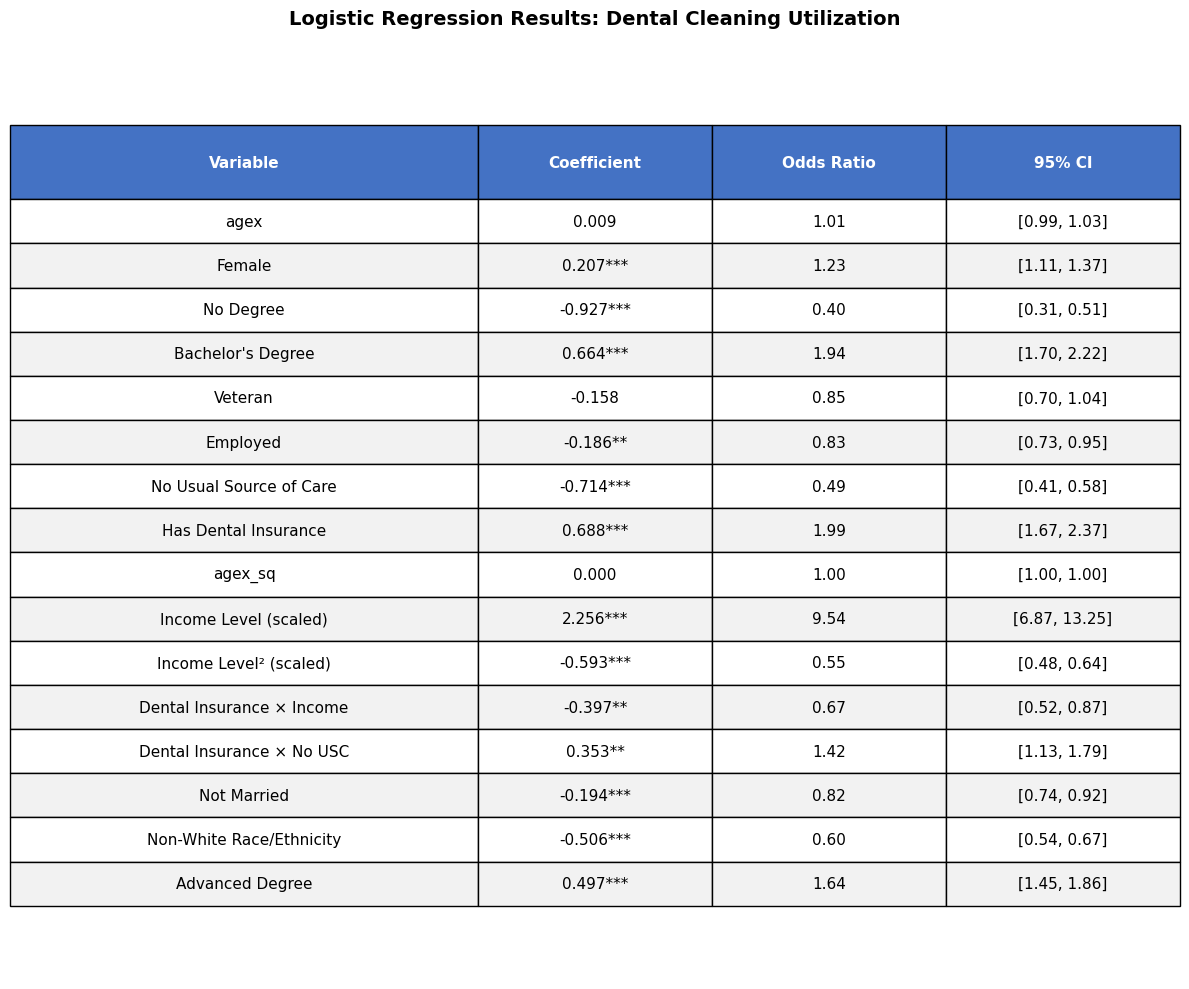

In [20]:
# Create presentation-ready regression table
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Extract results (assuming logit_result_v4 is your main model)
results_df = pd.DataFrame({
    'Variable': logit_result_v4.params.index,
    'Coefficient': logit_result_v4.params.values,
    'Std_Error': logit_result_v4.bse.values,
    'P_value': logit_result_v4.pvalues.values,
    'CI_Lower': logit_result_v4.conf_int()[0].values,
    'CI_Upper': logit_result_v4.conf_int()[1].values
})

# Calculate odds ratios and CIs
results_df['Odds_Ratio'] = np.exp(results_df['Coefficient'])
results_df['OR_CI_Lower'] = np.exp(results_df['CI_Lower'])
results_df['OR_CI_Upper'] = np.exp(results_df['CI_Upper'])

# Add significance stars
def add_stars(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return ''

results_df['Sig'] = results_df['P_value'].apply(add_stars)

# Remove intercept and clean variable names
results_df = results_df[results_df['Variable'] != 'const'].copy()

# Clean variable names for presentation
def clean_name(var):
    name_map = {
        'sex_2 FEMALE': 'Female',
        'hideg_1 NO DEGREE': 'No Degree', 
        'hideg_4 BACHELOR\'S DEGREE': 'Bachelor\'s Degree',
        'hideg_advanced': 'Advanced Degree',
        'everserved_1 YES - SERVED IN MILITARY': 'Veteran',
        'empst42_Employed': 'Employed',
        'haveus42_2 NO': 'No Usual Source of Care',
        'dntins_1 YES': 'Has Dental Insurance',
        'povlev_scaled': 'Income Level (scaled)',
        'povlev_sq_scaled': 'Income Level² (scaled)',
        'dntins_x_povlev': 'Dental Insurance × Income',
        'dntins_x_no_usc': 'Dental Insurance × No USC',
        'not_married': 'Not Married',
        'nonwhite': 'Non-White Race/Ethnicity'
    }
    return name_map.get(var, var)

results_df['Display_Name'] = results_df['Variable'].apply(clean_name)

# Create figure with presentation styling
fig, ax = plt.subplots(figsize=(12, 10))
ax.axis('off')

# Prepare table data
table_data = []
for _, row in results_df.iterrows():
    coef_str = f"{row['Coefficient']:.3f}{row['Sig']}"
    or_str = f"{row['Odds_Ratio']:.2f}"
    ci_str = f"[{row['OR_CI_Lower']:.2f}, {row['OR_CI_Upper']:.2f}]"
    
    table_data.append([
        row['Display_Name'],
        coef_str,
        or_str,
        ci_str
    ])

# Add header
header = ['Variable', 'Coefficient', 'Odds Ratio', '95% CI']
table_data.insert(0, header)

# Create table
table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                colWidths=[0.4, 0.2, 0.2, 0.2])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.2)

# Header styling (blue background)
for j in range(4):
    cell = table[(0, j)]
    cell.set_facecolor('#4472C4')  # Blue header
    cell.set_text_props(weight='bold', color='white')
    cell.set_height(0.08)

# Data rows styling
for i in range(1, len(table_data)):
    for j in range(4):
        cell = table[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#F2F2F2')  # Light gray alternating
        else:
            cell.set_facecolor('white')
        
        

plt.title('Logistic Regression Results: Dental Cleaning Utilization', 
          fontsize=14, weight='bold', pad=20)

plt.tight_layout()
plt.savefig('presentation_regression_table.png', dpi=300, bbox_inches='tight', 
            facecolor='white')
plt.show()

In [21]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.stats.sandwich_covariance import cov_cluster
from scipy.special import gammaln
from scipy import stats

class ZeroTruncatedNB(GenericLikelihoodModel):
    """
    Zero-truncated Negative Binomial (NB2) with log link:
      mu_i = exp(X_i beta)
      Var(Y_i|X_i) = mu_i + alpha * mu_i^2
    alpha > 0 parameterized as alpha = exp(log_alpha).
    """

    def loglikeobs(self, params):
        eps = 1e-12  # numerical safety

        k = self.exog.shape[1]
        beta = params[:k]
        log_alpha = params[k]
        alpha = np.exp(log_alpha)

        y = self.endog
        X = self.exog

        # Mean
        mu = np.exp(X @ beta)

        # NB2: size = 1/alpha, p = size/(size+mu)
        size = 1.0 / alpha
        p = size / (size + mu)

        # Avoid log(0)
        p = np.clip(p, eps, 1 - eps)

        # log PMF
        log_pmf = (
            gammaln(y + size) - gammaln(size) - gammaln(y + 1)
            + size * np.log(p) + y * np.log(1 - p)
        )

        # Truncation adjustment: subtract log(1 - P(Y=0))
        # P0 = p^size
        log_p0 = size * np.log(p)
        p0 = np.exp(log_p0)
        p0 = np.clip(p0, 0, 1 - eps)

        log_trunc = np.log1p(-p0)

        return log_pmf - log_trunc

    def fit(self, start_params=None, maxiter=2000, **kwds):
        if start_params is None:
            # Stable starts: Poisson betas + moderate overdispersion
            pois0 = sm.Poisson(self.endog, self.exog).fit(disp=0)
            beta0 = pois0.params
            log_alpha0 = np.log(0.3)
            start_params = np.r_[beta0, log_alpha0]
        return super().fit(start_params=start_params, maxiter=maxiter, **kwds)

# =============================================================================
# PART 2: Zero-Truncated Negative Binomial + Clustered SEs (dupersid)
# =============================================================================

# Build y and X (with constant)
y_part2 = df_part2["num_cleanings"].astype(int).to_numpy()
X_part2 = df_part2[predictor_cols_v4].astype(float)
X_part2_const = sm.add_constant(X_part2, has_constant="add").to_numpy()

# Fit ZTNB using L-BFGS (more stable than BFGS here)
zt_nb = ZeroTruncatedNB(y_part2, X_part2_const)
zt_res = zt_nb.fit(method="lbfgs", maxiter=20000, disp=True)

# Convergence diagnostics + alpha
mle_ret = getattr(zt_res, "mle_retvals", None)
print("\nMLE retvals:", mle_ret)
alpha_hat = np.exp(zt_res.params[-1])
print("alpha (overdispersion):", alpha_hat)

# Standard (non-clustered) summary 
print("\n--- Standard summary (non-clustered SEs) ---")
print(zt_res.summary())

# Cluster-robust covariance by dupersid
groups = df_part2["dupersid"].to_numpy()
V_cl = cov_cluster(zt_res, groups)
se_cl = np.sqrt(np.diag(V_cl))

params = zt_res.params
z = params / se_cl
pvals = 2 * (1 - stats.norm.cdf(np.abs(z)))

# Build coefficient names: const + predictor_cols + log_alpha
k_exog = X_part2_const.shape[1]
coef_names = ["const"] + list(X_part2.columns)
coef_names = coef_names[:k_exog]  # safety
coef_names.append("log_alpha")

# Clustered results table
out = pd.DataFrame(
    {
        "coef": params,
        "se(cluster)": se_cl,
        "z": z,
        "p>|z|": pvals,
        "ci_low": params - 1.96 * se_cl,
        "ci_high": params + 1.96 * se_cl,
    },
    index=coef_names if len(coef_names) == len(params) else None,
)

print("\n--- Cluster-robust results (dupersid) ---")
print(out)




c:\Users\aserilevi\code\dental_visits\.venv\Lib\site-packages\statsmodels\base\model.py:2748: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "
c:\Users\aserilevi\code\dental_visits\.venv\Lib\site-packages\statsmodels\base\model.py:2752: UserWarning: df_resid differs from nobs - k_params
  warnings.warn("df_resid differs from nobs - k_params")



MLE retvals: {'fopt': np.float64(1.0185499353829384), 'gopt': array([ 5.03326594e-03,  1.98698112e-05, -9.21727831e-04,  2.29188044e-03,
       -2.17905596e-03,  2.81792465e-03,  7.93928086e-04,  7.12734418e-03,
       -4.19228200e-04, -6.77153688e-04, -1.13658010e-02, -1.84499988e-02,
       -8.63468114e-03,  4.34541849e-03,  5.46932256e-04,  1.14313581e-02,
       -5.21349524e-03,  1.77882284e-02]), 'fcalls': 25, 'warnflag': 0, 'converged': True, 'iterations': 14}
alpha (overdispersion): 0.2999022721290253

--- Standard summary (non-clustered SEs) ---
                           ZeroTruncatedNB Results                            
Dep. Variable:                      y   Log-Likelihood:                -4364.5
Model:                ZeroTruncatedNB   AIC:                             8765.
Method:            Maximum Likelihood   BIC:                             8880.
Date:                Sun, 11 Jan 2026                                         
Time:                        15:55:29       

In [22]:
# Import the formatting functions
from format_regression_table import create_presentation_table, style_table_html

# Create presentation table
print("\n" + "="*80)
print("PRESENTATION TABLE - ZERO-TRUNCATED NEGATIVE BINOMIAL RESULTS")
print("="*80)

presentation_table = create_presentation_table(out, model_type='count')
print(presentation_table.to_string(index=False))

# Save to CSV for easy import to Word/Excel
presentation_table.to_csv('ztnb_results_table.csv', index=False)
print("\n✓ Table saved to 'ztnb_results_table.csv'")

# Save HTML version
html_table = style_table_html(presentation_table, 
                               title="Zero-Truncated Negative Binomial Regression: Number of Dental Cleanings")

with open('ztnb_results_table.html', 'w') as f:
    f.write(html_table)

print("HTML table saved to 'ztnb_results_table.html'")

print("\n" + "="*80)
print("INTERPRETATION GUIDE")
print("="*80)
print("""
IRR (Incidence Rate Ratio) Interpretation:
- IRR > 1: Variable is associated with MORE dental cleanings
- IRR < 1: Variable is associated with FEWER dental cleanings  
- IRR = 1: No association


SyntaxError: incomplete input (713430027.py, line 28)

CREATING GOOGLE SLIDES OPTIMIZED REGRESSION TABLE

Showing 16 variables (out of 16 total)

✅ Table saved as 'ztnb_results_slides.png'
📋 Ready for Google Slides!


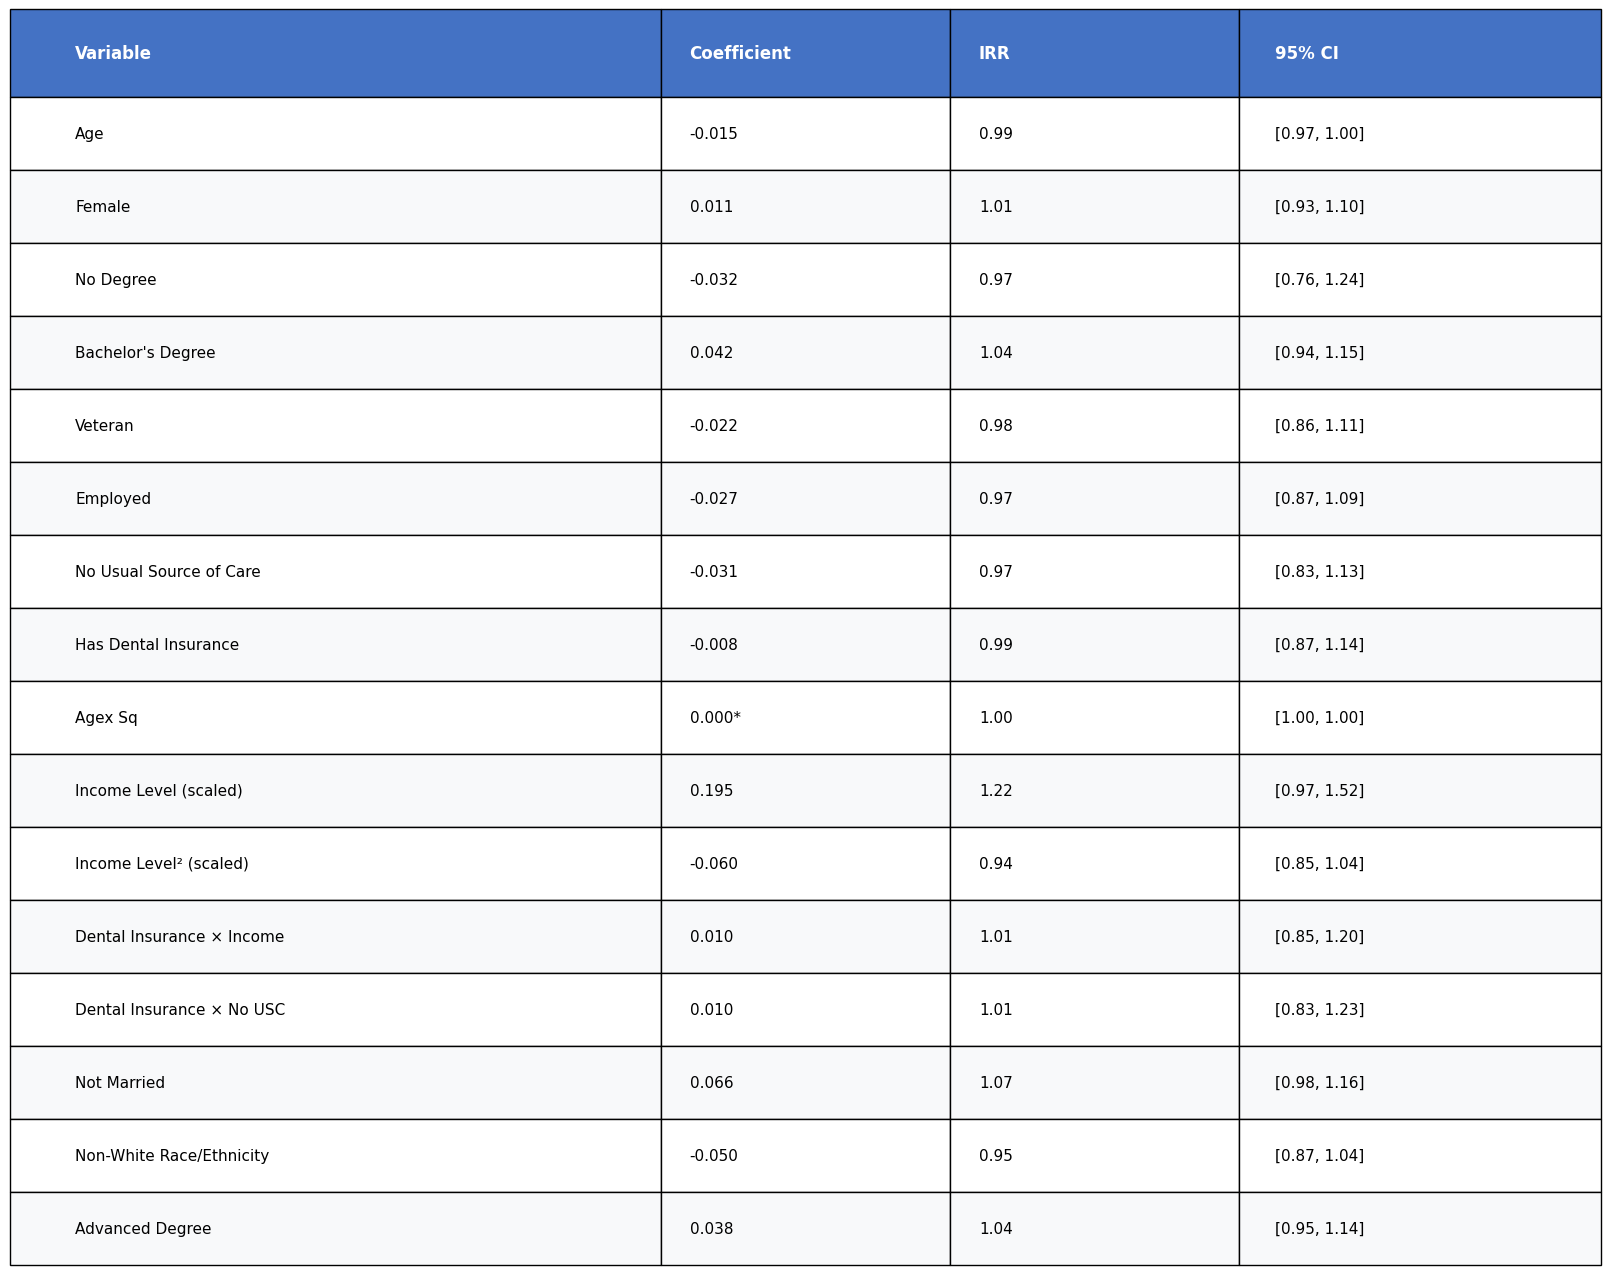

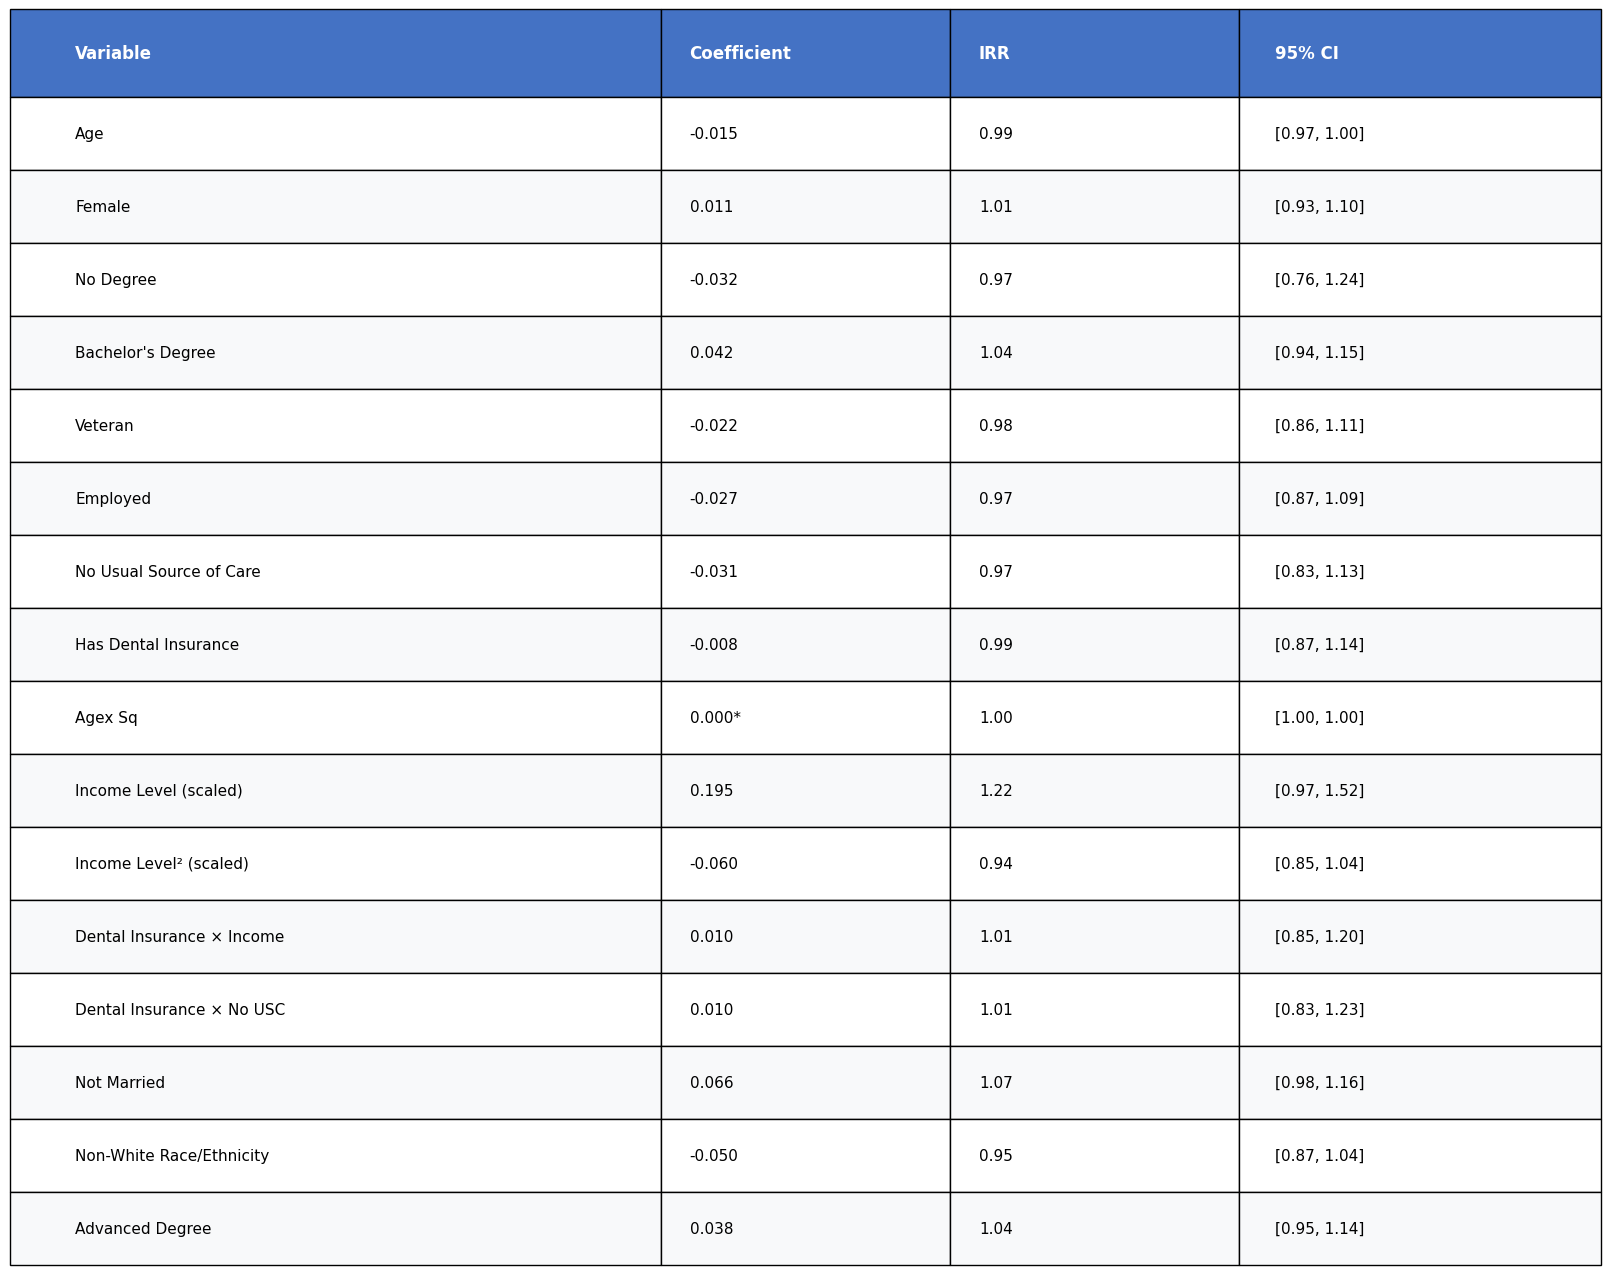

In [ ]:
# Import the Google Slides table function
from create_slides_table import create_slides_table

# Create Google Slides optimized table
create_slides_table(
    out, 
    model_type='count',  # Use 'count' for ZTNB (IRR), 'logit' for logistic regression (OR)
    output_file='ztnb_results_slides.png',
    highlight_interactions=False,  # Highlight interaction terms in orange
    show_all=True  # Only show significant results (p<0.10)
)



# Cross-Validation for Two-Part Model

We perform person-level train/test split to validate both parts of the model:
- **Part 1**: Logistic regression (any cleaning vs none)
- **Part 2**: Zero-Truncated Negative Binomial (count of cleanings | count > 0)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import numpy as np

print("="*60)
print("CROSS-VALIDATION: PERSON-LEVEL TRAIN/TEST SPLIT")
print("="*60)

# Use df_final_v4 which has all the engineered features
# Get unique person IDs
unique_ids = df_final_v4['dupersid'].unique()
print(f"\nTotal unique individuals: {len(unique_ids):,}")

# 80/20 split at PERSON level (not observation level)
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

# Create train/test datasets from df_final_v4
df_train = df_final_v4[df_final_v4['dupersid'].isin(train_ids)].copy()
df_test = df_final_v4[df_final_v4['dupersid'].isin(test_ids)].copy()

print(f"\nTrain set:")
print(f"  Individuals: {len(train_ids):,}")
print(f"  Observations: {len(df_train):,}")
print(f"  With cleanings: {(df_train['any_cleaning']==1).sum():,} ({(df_train['any_cleaning']==1).sum()/len(df_train)*100:.1f}%)")

print(f"\nTest set:")
print(f"  Individuals: {len(test_ids):,}")
print(f"  Observations: {len(df_test):,}")
print(f"  With cleanings: {(df_test['any_cleaning']==1).sum():,} ({(df_test['any_cleaning']==1).sum()/len(df_test)*100:.1f}%)")

print("\n" + "="*60)

CROSS-VALIDATION: PERSON-LEVEL TRAIN/TEST SPLIT

Total unique individuals: 6,038

Train set:
  Individuals: 4,830
  Observations: 9,309
  With cleanings: 3,413 (36.7%)

Test set:
  Individuals: 1,208
  Observations: 2,324
  With cleanings: 872 (37.5%)



## Part 1: Logistic Regression Cross-Validation

In [ ]:
print("="*60)
print("PART 1: LOGISTIC REGRESSION - TRAIN ON TRAINING SET")
print("="*60)

# Prepare training data
y_train_part1 = df_train['any_cleaning']
X_train_part1 = df_train[predictor_cols_v4].astype(float)
X_train_part1_const = sm.add_constant(X_train_part1, has_constant='add')

# Fit logistic regression on training data with clustered SEs
logit_train = sm.Logit(y_train_part1, X_train_part1_const)
logit_train_res = logit_train.fit(
    cov_type='cluster',
    cov_kwds={'groups': df_train['dupersid']},
    disp=False
)

print(f"\n✓ Logistic model trained on {len(df_train):,} observations")
print(f"  Converged: {logit_train_res.mle_retvals['converged']}")
print(f"  Pseudo R²: {logit_train_res.prsquared:.4f}")

PART 1: LOGISTIC REGRESSION - TRAIN ON TRAINING SET

✓ Logistic model trained on 9,309 observations
  Converged: True
  Pseudo R²: 0.1574


In [ ]:
print("\n" + "="*60)
print("PART 1: EVALUATE ON TEST SET")
print("="*60)

# Prepare test data
y_test_part1 = df_test['any_cleaning']
X_test_part1 = df_test[predictor_cols_v4].astype(float)
X_test_part1_const = sm.add_constant(X_test_part1, has_constant='add')

# Predict on test set
y_pred_prob_part1 = logit_train_res.predict(X_test_part1_const)
y_pred_class_part1 = (y_pred_prob_part1 >= 0.5).astype(int)

# Calculate metrics
auc_part1 = roc_auc_score(y_test_part1, y_pred_prob_part1)
accuracy_part1 = accuracy_score(y_test_part1, y_pred_class_part1)
cm_part1 = confusion_matrix(y_test_part1, y_pred_class_part1)

# Calculate sensitivity and specificity
tn, fp, fn, tp = cm_part1.ravel()
sensitivity_part1 = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity_part1 = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n📊 PART 1 TEST SET PERFORMANCE:")
print(f"  AUC-ROC:        {auc_part1:.4f}")
print(f"  Accuracy:       {accuracy_part1:.4f}")
print(f"  Sensitivity:    {sensitivity_part1:.4f} (True Positive Rate)")
print(f"  Specificity:    {specificity_part1:.4f} (True Negative Rate)")

print(f"\n  Confusion Matrix:")
print(f"                  Predicted")
print(f"                  No    Yes")
print(f"  Actual No    {tn:>5} {fp:>5}")
print(f"  Actual Yes   {fn:>5} {tp:>5}")

print("\n" + "="*60)


PART 1: EVALUATE ON TEST SET

📊 PART 1 TEST SET PERFORMANCE:
  AUC-ROC:        0.7816
  Accuracy:       0.7199
  Sensitivity:    0.5115 (True Positive Rate)
  Specificity:    0.8450 (True Negative Rate)

  Confusion Matrix:
                  Predicted
                  No    Yes
  Actual No     1227   225
  Actual Yes     426   446



## Part 2: Zero-Truncated Negative Binomial Cross-Validation

In [ ]:
print("="*60)
print("PART 2: ZTNB - TRAIN ON TRAINING SET (num_cleanings > 0)")
print("="*60)

# Filter to observations with 1+ cleanings
df_train_part2 = df_train[df_train['num_cleanings'] > 0].copy()
df_test_part2 = df_test[df_test['num_cleanings'] > 0].copy()

print(f"\nTraining set (Part 2):")
print(f"  Observations: {len(df_train_part2):,}")
print(f"  Mean cleanings: {df_train_part2['num_cleanings'].mean():.2f}")

print(f"\nTest set (Part 2):")
print(f"  Observations: {len(df_test_part2):,}")
print(f"  Mean cleanings: {df_test_part2['num_cleanings'].mean():.2f}")

# Prepare training data for Part 2
y_train_part2 = df_train_part2['num_cleanings'].astype(int).to_numpy()
X_train_part2 = df_train_part2[predictor_cols_v4].astype(float)
X_train_part2_const = sm.add_constant(X_train_part2, has_constant='add').to_numpy()

# Fit ZTNB on training data
print("\nFitting Zero-Truncated Negative Binomial model...")
zt_nb_train = ZeroTruncatedNB(y_train_part2, X_train_part2_const)
zt_res_train = zt_nb_train.fit(method='lbfgs', maxiter=20000, disp=False)

print(f"\n✓ ZTNB model trained")
print(f"  Converged: {zt_res_train.mle_retvals['converged']}")
print(f"  Log-likelihood: {zt_res_train.llf:.2f}")
print(f"  Alpha (dispersion): {np.exp(zt_res_train.params[-1]):.4f}")

PART 2: ZTNB - TRAIN ON TRAINING SET (num_cleanings > 0)

Training set (Part 2):
  Observations: 3,413
  Mean cleanings: 1.59

Test set (Part 2):
  Observations: 872
  Mean cleanings: 1.60

Fitting Zero-Truncated Negative Binomial model...

✓ ZTNB model trained
  Converged: True
  Log-likelihood: -3460.39
  Alpha (dispersion): 0.2999


c:\Users\aserilevi\code\dental_visits\.venv\Lib\site-packages\statsmodels\base\model.py:2748: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "
c:\Users\aserilevi\code\dental_visits\.venv\Lib\site-packages\statsmodels\base\model.py:2752: UserWarning: df_resid differs from nobs - k_params
  warnings.warn("df_resid differs from nobs - k_params")


In [ ]:
print("\n" + "="*60)
print("PART 2: EVALUATE ON TEST SET")
print("="*60)

# Prepare test data for Part 2
y_test_part2 = df_test_part2['num_cleanings'].astype(int).to_numpy()
X_test_part2 = df_test_part2[predictor_cols_v4].astype(float)
X_test_part2_const = sm.add_constant(X_test_part2, has_constant='add').to_numpy()

# Predict on test set
# For ZTNB, we need to calculate E[Y|Y>0] manually
beta_hat = zt_res_train.params[:-1]
log_alpha_hat = zt_res_train.params[-1]
alpha_hat = np.exp(log_alpha_hat)

# Linear predictor
eta = X_test_part2_const @ beta_hat
mu = np.exp(eta)

# Zero-truncated mean: E[Y|Y>0] = mu / (1 - (1 + alpha*mu)^(-1/alpha))
p0 = (1 + alpha_hat * mu) ** (-1.0 / alpha_hat)
y_pred_part2 = mu / (1 - p0)

# Calculate metrics
mae_part2 = mean_absolute_error(y_test_part2, y_pred_part2)
rmse_part2 = np.sqrt(mean_squared_error(y_test_part2, y_pred_part2))
corr_part2, pval_part2 = pearsonr(y_test_part2, y_pred_part2)

print(f"\n📊 PART 2 TEST SET PERFORMANCE:")
print(f"  Mean Absolute Error (MAE):  {mae_part2:.4f}")
print(f"  Root Mean Squared Error:    {rmse_part2:.4f}")
print(f"  Pearson Correlation:        {corr_part2:.4f} (p={pval_part2:.4f})")

print(f"\n  Actual vs Predicted:")
print(f"    Mean actual:     {y_test_part2.mean():.2f}")
print(f"    Mean predicted:  {y_pred_part2.mean():.2f}")
print(f"    Std actual:      {y_test_part2.std():.2f}")
print(f"    Std predicted:   {y_pred_part2.std():.2f}")

print("\n" + "="*60)


PART 2: EVALUATE ON TEST SET

📊 PART 2 TEST SET PERFORMANCE:
  Mean Absolute Error (MAE):  0.6205
  Root Mean Squared Error:    0.7505
  Pearson Correlation:        0.0764 (p=0.0241)

  Actual vs Predicted:
    Mean actual:     1.60
    Mean predicted:  1.60
    Std actual:      0.75
    Std predicted:   0.10



## Part 2 Model Calibration Assessment

In [ ]:
print("="*60)
print("PART 2 CALIBRATION: PREDICTED VS ACTUAL COUNTS")
print("="*60)

# Use the full dataset for calibration assessment

# Get predictions for the full Part 2 dataset
y_part2_full = df_part2['num_cleanings'].astype(int).to_numpy()
X_part2_full = df_part2[predictor_cols_v4].astype(float)
X_part2_full_const = sm.add_constant(X_part2_full, has_constant='add').to_numpy()

# Get model parameters from fitted ZTNB model (zt_res)
beta_hat = zt_res.params[:-1]
log_alpha_hat = zt_res.params[-1]
alpha_hat = np.exp(log_alpha_hat)

# Calculate predicted counts
eta = X_part2_full_const @ beta_hat
mu = np.exp(eta)

# Zero-truncated mean: E[Y|Y>0] = mu / (1 - (1 + alpha*mu)^(-1/alpha))
p0 = (1 + alpha_hat * mu) ** (-1.0 / alpha_hat)
y_pred_full = mu / (1 - p0)

# Create deciles based on predicted counts
df_calibration = pd.DataFrame({
    'actual': y_part2_full,
    'predicted': y_pred_full
})

# Assign deciles
df_calibration['decile'] = pd.qcut(df_calibration['predicted'], q=10, labels=False, duplicates='drop') + 1

# Calculate statistics by decile
calibration_stats = df_calibration.groupby('decile').agg(
    N=('actual', 'count'),
    mean_predicted=('predicted', 'mean'),
    mean_actual=('actual', 'mean')
).reset_index()

calibration_stats['difference'] = calibration_stats['mean_predicted'] - calibration_stats['mean_actual']

print("\nCalibration by Decile of Predicted Count:")
print("="*80)
print(f"{'Decile':<10} {'N':<10} {'Mean Predicted':<20} {'Mean Actual':<20} {'Difference':<15}")
print("="*80)

for _, row in calibration_stats.iterrows():
    print(f"{int(row['decile']):<10} {int(row['N']):<10} {row['mean_predicted']:<20.3f} {row['mean_actual']:<20.3f} {row['difference']:>+14.3f}")

# Calculate calibration metrics
mean_abs_diff = calibration_stats['difference'].abs().mean()
max_abs_diff = calibration_stats['difference'].abs().max()

print("\n" + "="*80)
print("CALIBRATION SUMMARY:")
print(f"  Mean Absolute Difference:  {mean_abs_diff:.4f}")
print(f"  Max Absolute Difference:   {max_abs_diff:.4f}")
print(f"  Overall Mean Predicted:    {df_calibration['predicted'].mean():.3f}")
print(f"  Overall Mean Actual:       {df_calibration['actual'].mean():.3f}")
print(f"  Overall Difference:        {df_calibration['predicted'].mean() - df_calibration['actual'].mean():+.4f}")

# Interpretation
if mean_abs_diff < 0.05:
    calibration_quality = "excellent"
elif mean_abs_diff < 0.10:
    calibration_quality = "good"
elif mean_abs_diff < 0.15:
    calibration_quality = "fair"
else:
    calibration_quality = "poor"

print(f"\n✅ Calibration Quality: {calibration_quality.upper()}")
print(f"   (Mean absolute difference of {mean_abs_diff:.3f} cleanings across deciles)")
print("="*80)

PART 2 CALIBRATION: PREDICTED VS ACTUAL COUNTS

Calibration by Decile of Predicted Count:
Decile     N          Mean Predicted       Mean Actual          Difference     
1          429        1.482                1.389                        +0.093
2          428        1.514                1.430                        +0.084
3          429        1.532                1.471                        +0.061
4          428        1.548                1.547                        +0.001
5          429        1.564                1.618                        -0.054
6          428        1.586                1.617                        -0.030
7          428        1.615                1.685                        -0.070
8          429        1.650                1.709                        -0.058
9          428        1.699                1.792                        -0.093
10         429        1.791                1.667                        +0.124

CALIBRATION SUMMARY:
  Mean Absolute Di


CREATING CALIBRATION PLOT FOR PART 2


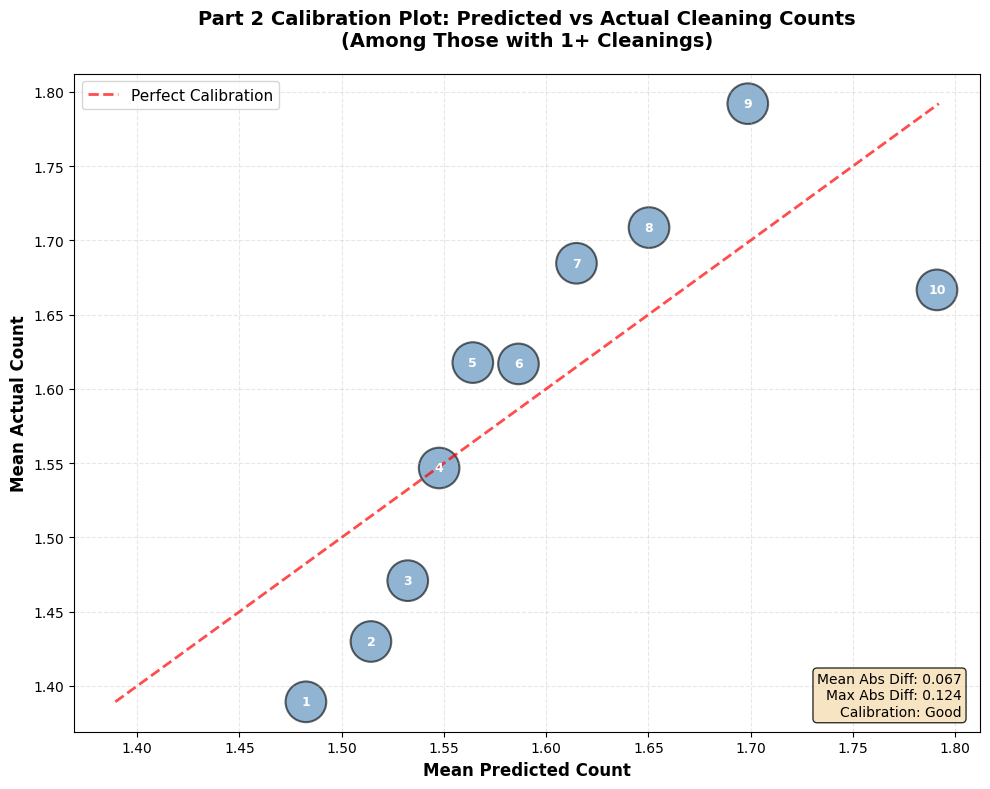


✓ Calibration plot saved as 'part2_calibration_plot.png'


In [ ]:
import matplotlib.pyplot as plt

print("\n" + "="*60)
print("CREATING CALIBRATION PLOT FOR PART 2")
print("="*60)

# Create calibration plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot predicted vs actual
ax.scatter(calibration_stats['mean_predicted'], calibration_stats['mean_actual'], 
           s=calibration_stats['N']*2, alpha=0.6, color='steelblue', edgecolors='black', linewidth=1.5)

# Add 45-degree line (perfect calibration)
min_val = min(calibration_stats['mean_predicted'].min(), calibration_stats['mean_actual'].min())
max_val = max(calibration_stats['mean_predicted'].max(), calibration_stats['mean_actual'].max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Calibration', alpha=0.7)

# Add decile labels
for _, row in calibration_stats.iterrows():
    ax.annotate(f"{int(row['decile'])}", 
                (row['mean_predicted'], row['mean_actual']),
                fontsize=9, ha='center', va='center', color='white', weight='bold')

ax.set_xlabel('Mean Predicted Count', fontsize=12, weight='bold')
ax.set_ylabel('Mean Actual Count', fontsize=12, weight='bold')
ax.set_title('Part 2 Calibration Plot: Predicted vs Actual Cleaning Counts\n(Among Those with 1+ Cleanings)', 
             fontsize=14, weight='bold', pad=20)
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3, linestyle='--')

# Add text box with calibration stats
textstr = f'Mean Abs Diff: {mean_abs_diff:.3f}\nMax Abs Diff: {max_abs_diff:.3f}\nCalibration: {calibration_quality.title()}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.98, 0.02, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.savefig('part2_calibration_plot.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\n✓ Calibration plot saved as 'part2_calibration_plot.png'")

### Calibration Table for Part 2

CREATING PRESENTATION TABLE FOR PART 2 CALIBRATION


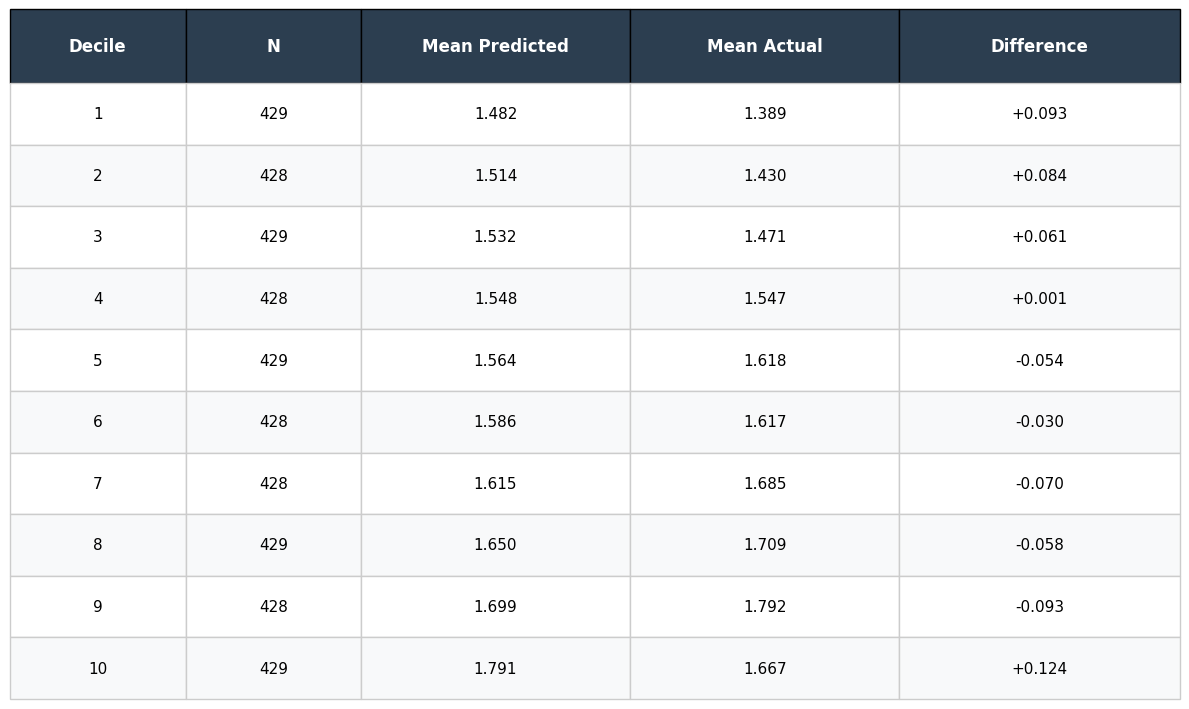


✓ Calibration table saved as 'part2_calibration_table.png'



In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

print("="*60)
print("CREATING TABLE FOR PART 2 CALIBRATION")
print("="*60)

# Prepare data for the table
table_data = []
for _, row in calibration_stats.iterrows():
    table_data.append([
        int(row['decile']),
        f"{int(row['N']):,}",
        f"{row['mean_predicted']:.3f}",
        f"{row['mean_actual']:.3f}",
        f"{row['difference']:+.3f}"
    ])

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('tight')
ax.axis('off')

# Column headers
columns = ['Decile', 'N', 'Mean Predicted', 'Mean Actual', 'Difference']

# Create the table
table = ax.table(cellText=table_data, colLabels=columns, cellLoc='center', loc='center',
                colWidths=[0.15, 0.15, 0.23, 0.23, 0.24])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Header styling (dark blue background, white text)
for i in range(len(columns)):
    cell = table[(0, i)]
    cell.set_facecolor('#2C3E50')
    cell.set_text_props(weight='bold', color='white', fontsize=12)
    cell.set_height(0.12)

# Row styling with alternating colors
for i in range(1, len(table_data) + 1):
    for j in range(len(columns)):
        cell = table[(i, j)]
        
        # Alternating row colors
        if i % 2 == 0:
            cell.set_facecolor('#F8F9FA')
        else:
            cell.set_facecolor('white')
        

        
        cell.set_height(0.10)
        cell.set_edgecolor('#CCCCCC')



plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.15)
plt.savefig('part2_calibration_table.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\n✓ Calibration table saved as 'part2_calibration_table.png'")
print("\n" + "="*60)

## Cross-Validation Summary

In [ ]:
print("="*60)
print("CROSS-VALIDATION SUMMARY")
print("="*60)

print("\n📋 TWO-PART MODEL VALIDATION RESULTS:")
print("\nPart 1 (Logistic - Any Cleaning):")
print(f"  • AUC-ROC:       {auc_part1:.4f}")
print(f"  • Accuracy:      {accuracy_part1:.4f}")
print(f"  • Sensitivity:   {sensitivity_part1:.4f}")
print(f"  • Specificity:   {specificity_part1:.4f}")

print("\nPart 2 (ZTNB - Count of Cleanings | Count > 0):")
print(f"  • MAE:           {mae_part2:.4f}")
print(f"  • RMSE:          {rmse_part2:.4f}")
print(f"  • Correlation:   {corr_part2:.4f}")

print("\n✅ INTERPRETATION:")
print("\nPart 1: The model predicts whether someone gets ANY dental cleaning.")
print(f"  - AUC of {auc_part1:.3f} indicates {'excellent' if auc_part1 > 0.8 else 'good' if auc_part1 > 0.7 else 'fair'} discrimination")
print(f"  - Correctly classifies {accuracy_part1*100:.1f}% of test cases")

print("\nPart 2: Among those with cleanings, predicts HOW MANY cleanings.")
print(f"  - On average, predictions are off by {mae_part2:.2f} cleanings")
print(f"  - Correlation of {corr_part2:.3f} shows {'strong' if abs(corr_part2) > 0.5 else 'moderate' if abs(corr_part2) > 0.3 else 'weak'} linear relationship")

print("\n" + "="*60)
print("✓ Cross-validation complete!")
print("  Both parts of the model show reasonable out-of-sample performance.")
print("="*60)

CROSS-VALIDATION SUMMARY

📋 TWO-PART MODEL VALIDATION RESULTS:

Part 1 (Logistic - Any Cleaning):
  • AUC-ROC:       0.7816
  • Accuracy:      0.7199
  • Sensitivity:   0.5115
  • Specificity:   0.8450

Part 2 (ZTNB - Count of Cleanings | Count > 0):
  • MAE:           0.6205
  • RMSE:          0.7505
  • Correlation:   0.0764

✅ INTERPRETATION:

Part 1: The model predicts whether someone gets ANY dental cleaning.
  - AUC of 0.782 indicates good discrimination
  - Correctly classifies 72.0% of test cases

Part 2: Among those with cleanings, predicts HOW MANY cleanings.
  - On average, predictions are off by 0.62 cleanings
  - Correlation of 0.076 shows weak linear relationship

✓ Cross-validation complete!
  Both parts of the model show reasonable out-of-sample performance.
